[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/leippold/HAI-Frontier/blob/main/arxiv_author_enrichment.ipynb)

# ArXiv Author Enrichment & Selection Robustness Analysis

This notebook enriches ICLR submission data with author affiliations and reputation metrics,
then runs robustness tests to address the referee critique:

> **"The negative correlation between AI content and quality is selection, not treatment.
> Low-ability researchers simply overuse AI."**

## Key Tests:
1. **Stratified Analysis**: Does the AI-quality relationship persist among high-reputation authors?
2. **Interaction Model**: AI × h-index interaction to test uniform vs. heterogeneous effects
3. **Component Analysis**: Does Soundness decline more than Presentation across all reputation tiers?

If the pattern holds among high-h-index authors, the selection argument is ruled out.

## 1. Setup

In [6]:
# Install required packages
!pip install -q pandas numpy scipy statsmodels requests tqdm matplotlib seaborn

In [7]:
import os
import sys

#@title Configuration { display-mode: "form" }

#@markdown ### Data Location
#@markdown Path to your raw data folder (Google Drive):
DATA_PATH = "/content/drive/MyDrive/HAI_Data"  #@param {type:"string"}

#@markdown Expected files in DATA_PATH:
#@markdown - `iclr_pangram_submissions.csv`
#@markdown - `iclr_pangram_reviews.csv`

#@markdown ---
#@markdown ### GitHub Configuration
GITHUB_USER = "leippold"  #@param {type:"string"}
REPO_NAME = "HAI-Frontier"  #@param {type:"string"}

#@markdown ---
#@markdown ### Enriched Data Location (in GitHub repo)
#@markdown If this file exists, skip API enrichment and load directly:
ENRICHED_DATA_PATH = "data/iclr_submissions_enriched.csv"  #@param {type:"string"}

# Load GitHub token from Colab Secrets
try:
    from google.colab import userdata
    GITHUB_TOKEN = userdata.get('GITHUB_TOKEN')
    print("GitHub token loaded from Colab Secrets")
except:
    GITHUB_TOKEN = None
    print("No GitHub token found - will skip git push operations")

# Define paths
SUBMISSIONS_PATH = os.path.join(DATA_PATH, 'iclr_pangram_submissions.csv')
REVIEWS_PATH = os.path.join(DATA_PATH, 'iclr_pangram_reviews.csv')

print(f"\nData paths configured:")
print(f"  Raw submissions: {SUBMISSIONS_PATH}")
print(f"  Raw reviews: {REVIEWS_PATH}")
print(f"  Enriched data (GitHub): {ENRICHED_DATA_PATH}")

GitHub token loaded from Colab Secrets

Data paths configured:
  Raw submissions: /content/drive/MyDrive/HAI_Data/iclr_pangram_submissions.csv
  Raw reviews: /content/drive/MyDrive/HAI_Data/iclr_pangram_reviews.csv
  Enriched data (GitHub): data/iclr_submissions_enriched.csv


In [8]:
#@title Clone Repository from GitHub
import os

# Ensure we're in a valid directory
%cd /content

# Clean up any existing clone
!rm -rf /content/{REPO_NAME}

# Clone the repo
if GITHUB_TOKEN:
    !git clone https://{GITHUB_TOKEN}@github.com/{GITHUB_USER}/{REPO_NAME}.git
else:
    !git clone https://github.com/{GITHUB_USER}/{REPO_NAME}.git

# Change to repo directory
%cd /content/{REPO_NAME}

# Show structure
print("\n📁 Repository structure:")
!find . -type f \( -name "*.py" -o -name "*.md" \) | head -20

/content
Cloning into 'HAI-Frontier'...
remote: Enumerating objects: 845, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 845 (delta 67), reused 64 (delta 46), pack-reused 743 (from 2)
Receiving objects: 100% (845/845), 37.99 MiB | 18.24 MiB/s, done.
Resolving deltas: 100% (442/442), done.
/content/HAI-Frontier

📁 Repository structure:
./STATISTICAL_METHODS_APPENDIX.md
./data/README.md
./docs/STATISTICAL_METHODS.md
./retraction_analysis/retraction_src/data_loading.py
./retraction_analysis/retraction_src/__init__.py
./retraction_analysis/README.md
./retraction_analysis/retraction_analysis_modules/descriptive.py
./retraction_analysis/retraction_analysis_modules/plotting_enhanced.py
./retraction_analysis/retraction_analysis_modules/survival.py
./retraction_analysis/retraction_analysis_modules/__init__.py
./retraction_analysis/retraction_analysis_modules/sample_construction.py
./retraction_analysis/run_all.py
./inline_dis

In [9]:
# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('colorblind')

print("Setup complete!")

Setup complete!


## 2. Load ICLR Data

In [10]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Verify data files exist
print("\nChecking data files...")
for path, name in [(SUBMISSIONS_PATH, "Submissions"), (REVIEWS_PATH, "Reviews")]:
    if os.path.exists(path):
        print(f"  ✓ {name}: {path}")
    else:
        print(f"  ✗ {name} NOT FOUND: {path}")
        print(f"    Please update DATA_PATH in the configuration cell above.")

Mounted at /content/drive

Checking data files...
  ✓ Submissions: /content/drive/MyDrive/HAI_Data/iclr_pangram_submissions.csv
  ✓ Reviews: /content/drive/MyDrive/HAI_Data/iclr_pangram_reviews.csv


In [11]:
# Add repo to Python path for imports
sys.path.insert(0, f'/content/{REPO_NAME}')
sys.path.insert(0, f'/content/{REPO_NAME}/iclr_analysis')

# Load raw data
from iclr_analysis.src.data_loading import load_data

submissions_df, reviews_df = load_data(SUBMISSIONS_PATH, REVIEWS_PATH)

print(f"Submissions: {len(submissions_df):,} papers")
print(f"Reviews: {len(reviews_df):,} reviews")
print(f"\nSubmissions columns: {list(submissions_df.columns)[:10]}...")
print(f"Reviews columns: {list(reviews_df.columns)[:10]}...")

Loaded 19,381 submissions, 75,800 reviews
Submissions: 19,381 papers
Reviews: 75,800 reviews

Submissions columns: ['title', 'openreview_url', 'abstract', 'avg_rating', 'ai_percentage', 'submission_number', 'pangram_dashboard_url']...
Reviews columns: ['paper_title', 'submission_number', 'soundness', 'presentation', 'contribution', 'rating', 'confidence', 'review_text', 'ai_classification']...


In [12]:
# Verify title column exists (required for enrichment if running)
if 'title' in submissions_df.columns:
    n_titles = submissions_df['title'].notna().sum()
    print(f"✓ Found 'title' column with {n_titles:,} non-null titles")
else:
    print("⚠️ WARNING: 'title' column not found - enrichment will fail!")

✓ Found 'title' column with 19,381 non-null titles


## 3. Load or Enrich Author Data

This section either:
1. **Loads pre-enriched data** from the GitHub repo (if available) - FAST
2. **Runs API enrichment** if enriched data doesn't exist - takes ~2-5 hours for 19k papers

The enriched data includes:
- **First/Last author**: name, university, country, h-index, citations
- **H-index sources**: OpenAlex (primary), Scopus (fallback), Semantic Scholar (last resort)

In [13]:
# Check if enriched data already exists in repo
ENRICHED_FULL_PATH = f'/content/{REPO_NAME}/{ENRICHED_DATA_PATH}'
SKIP_ENRICHMENT = os.path.exists(ENRICHED_FULL_PATH)

if SKIP_ENRICHMENT:
    print("=" * 60)
    print("PRE-ENRICHED DATA FOUND - Skipping API calls!")
    print("=" * 60)
    print(f"\nLoading from: {ENRICHED_FULL_PATH}")

    enriched_df = pd.read_csv(ENRICHED_FULL_PATH)

    # Add derived columns if not present
    from arxiv_integration import add_derived_columns
    if 'first_author_region' not in enriched_df.columns:
        enriched_df = add_derived_columns(enriched_df)

    print(f"\nLoaded {len(enriched_df):,} enriched papers")
    print(f"With h-index: {enriched_df['first_author_h_index'].notna().sum():,}")
    print(f"With country: {enriched_df['first_author_country'].notna().sum():,}")

else:
    print("=" * 60)
    print("NO PRE-ENRICHED DATA - Will run API enrichment")
    print("=" * 60)
    print(f"\nLooking for: {ENRICHED_FULL_PATH}")
    print("This will take several hours. Run the next cells to start enrichment.")
    print("\nTo skip enrichment in the future, save your enriched data to:")
    print(f"  {ENRICHED_DATA_PATH}")

PRE-ENRICHED DATA FOUND - Skipping API calls!

Loading from: /content/HAI-Frontier/data/iclr_submissions_enriched.csv

Loaded 19,381 enriched papers
With h-index: 6,476
With country: 3,275


In [14]:
# Country Code Mapping: Fill missing country names from country codes
# The add_derived_columns function now automatically maps country codes to names

print("=" * 60)
print("COUNTRY DATA COVERAGE (BEFORE MAPPING)")
print("=" * 60)

# Check coverage before mapping
for col in ['first_author_country', 'first_author_country_code',
            'last_author_country', 'last_author_country_code',
            'primary_country', 'primary_country_code']:
    if col in enriched_df.columns:
        count = enriched_df[col].notna().sum()
        print(f"  {col}: {count:,}")

# Re-apply add_derived_columns to fill missing country names from codes
from arxiv_integration import add_derived_columns
enriched_df = add_derived_columns(enriched_df)

print("\n" + "=" * 60)
print("COUNTRY DATA COVERAGE (AFTER CODE-TO-NAME MAPPING)")
print("=" * 60)

for col in ['first_author_country', 'last_author_country', 'primary_country']:
    if col in enriched_df.columns:
        count = enriched_df[col].notna().sum()
        total = len(enriched_df)
        print(f"  {col}: {count:,} ({100*count/total:.1f}%)")

# Show sample of mapped countries
print("\n" + "-" * 40)
print("TOP 10 FIRST AUTHOR COUNTRIES (from code mapping):")
print("-" * 40)
if 'first_author_country' in enriched_df.columns:
    countries = enriched_df['first_author_country'].value_counts().head(10)
    for country, count in countries.items():
        print(f"  {country}: {count:,}")

COUNTRY DATA COVERAGE (BEFORE MAPPING)
  first_author_country: 3,275
  first_author_country_code: 3,381
  last_author_country: 3,828
  last_author_country_code: 3,961
  primary_country: 0
  primary_country_code: 0

COUNTRY DATA COVERAGE (AFTER CODE-TO-NAME MAPPING)
  first_author_country: 3,275 (16.9%)
  last_author_country: 3,828 (19.8%)
  primary_country: 0 (0.0%)

----------------------------------------
TOP 10 FIRST AUTHOR COUNTRIES (from code mapping):
----------------------------------------
  China: 1,929
  United States: 564
  South Korea: 112
  United Kingdom: 81
  Hong Kong: 69
  Germany: 65
  Canada: 54
  India: 54
  Switzerland: 49
  France: 47


In [15]:
# Show enrichment summary
print("=" * 60)
print("ENRICHMENT SUMMARY")
print("=" * 60)

total = len(enriched_df)
matched = enriched_df['openalex_match_score'].notna().sum() if 'openalex_match_score' in enriched_df.columns else 0
with_h_index = enriched_df['first_author_h_index'].notna().sum()

# Check all country columns (prefer primary_country which uses all authors)
country_coverage = {}
for col in ['primary_country', 'first_author_country', 'last_author_country']:
    if col in enriched_df.columns:
        country_coverage[col] = enriched_df[col].notna().sum()

# Use best available country column for display
if 'primary_country' in country_coverage and country_coverage['primary_country'] > 0:
    with_country = country_coverage['primary_country']
    country_col = 'primary_country'
elif 'first_author_country' in country_coverage and country_coverage['first_author_country'] > 0:
    with_country = country_coverage['first_author_country']
    country_col = 'first_author_country'
else:
    with_country = 0
    country_col = None

print(f"\nTotal papers: {total:,}")
print(f"Matched (OpenAlex): {matched:,} ({100*matched/total:.1f}%)")
print(f"With h-index: {with_h_index:,} ({100*with_h_index/total:.1f}%)")
print(f"With country: {with_country:,} ({100*with_country/total:.1f}%)")

# Show country coverage breakdown
if country_coverage:
    print("\n  Country column coverage:")
    for col, count in country_coverage.items():
        print(f"    - {col}: {count:,}")

# H-index source breakdown
if 'first_author_h_index_source' in enriched_df.columns:
    print("\nH-index sources:")
    for source, count in enriched_df['first_author_h_index_source'].value_counts().items():
        print(f"  - {source}: {count:,}")

# Individual author h-index stats
print("\n" + "-" * 40)
print("INDIVIDUAL AUTHOR METRICS")
print("-" * 40)
h_values = enriched_df['first_author_h_index'].dropna()
if len(h_values) > 0:
    print(f"First author h-index: median={h_values.median():.0f}, mean={h_values.mean():.1f}")

h_last = enriched_df['last_author_h_index'].dropna() if 'last_author_h_index' in enriched_df.columns else []
if len(h_last) > 0:
    print(f"Last author h-index:  median={h_last.median():.0f}, mean={h_last.mean():.1f}")

# NEW: Aggregated metrics across ALL authors
if 'mean_author_h_index' in enriched_df.columns:
    print("\n" + "-" * 40)
    print("AGGREGATED METRICS (ALL AUTHORS)")
    print("-" * 40)

    mean_h = enriched_df['mean_author_h_index'].dropna()
    if len(mean_h) > 0:
        print(f"Mean author h-index (per paper):   median={mean_h.median():.1f}, mean={mean_h.mean():.1f}")

    median_h = enriched_df['median_author_h_index'].dropna()
    if len(median_h) > 0:
        print(f"Median author h-index (per paper): median={median_h.median():.1f}, mean={median_h.mean():.1f}")

    max_h = enriched_df['max_author_h_index'].dropna()
    if len(max_h) > 0:
        print(f"Max author h-index (per paper):    median={max_h.median():.0f}, mean={max_h.mean():.1f}")

    if 'n_authors' in enriched_df.columns:
        n_authors = enriched_df['n_authors'].dropna()
        print(f"\nAuthors per paper: median={n_authors.median():.0f}, mean={n_authors.mean():.1f}")

    if 'n_authors_with_h_index' in enriched_df.columns:
        n_with_h = enriched_df['n_authors_with_h_index'].dropna()
        print(f"Authors with h-index (per paper): median={n_with_h.median():.0f}, mean={n_with_h.mean():.1f}")

# Country breakdown
print("\n" + "-" * 40)
print("TOP COUNTRIES")
print("-" * 40)
if country_col and country_col in enriched_df.columns:
    countries = enriched_df[country_col].value_counts().head(10)
    for country, count in countries.items():
        print(f"  {country}: {count:,}")

# Region breakdown (if available)
region_col = f'{country_col.replace("_country", "")}_region' if country_col else None
if region_col and region_col in enriched_df.columns:
    print("\n" + "-" * 40)
    print("BY REGION")
    print("-" * 40)
    regions = enriched_df[region_col].value_counts()
    for region, count in regions.items():
        if region is not None:
            print(f"  {region}: {count:,}")

ENRICHMENT SUMMARY

Total papers: 19,381
Matched (OpenAlex): 6,491 (33.5%)
With h-index: 6,476 (33.4%)
With country: 3,275 (16.9%)

  Country column coverage:
    - primary_country: 0
    - first_author_country: 3,275
    - last_author_country: 3,828

H-index sources:
  - openalex: 5,913
  - semantic_scholar: 563
  - none: 15

----------------------------------------
INDIVIDUAL AUTHOR METRICS
----------------------------------------
First author h-index: median=4, mean=9.1
Last author h-index:  median=20, mean=26.0

----------------------------------------
AGGREGATED METRICS (ALL AUTHORS)
----------------------------------------
Mean author h-index (per paper):   median=14.1, mean=15.3
Median author h-index (per paper): median=9.5, mean=11.2
Max author h-index (per paper):    median=34, mean=39.2

Authors per paper: median=0, mean=2.1
Authors with h-index (per paper): median=0, mean=1.8

----------------------------------------
TOP COUNTRIES
----------------------------------------
  C

In [16]:
# Show enrichment summary
print("=" * 60)
print("ENRICHMENT SUMMARY")
print("=" * 60)

total = len(enriched_df)
matched = enriched_df['openalex_match_score'].notna().sum() if 'openalex_match_score' in enriched_df.columns else 0
with_h_index = enriched_df['first_author_h_index'].notna().sum()

# Use primary_country if available, otherwise fall back to first_author_country
if 'primary_country' in enriched_df.columns:
    with_country = enriched_df['primary_country'].notna().sum()
    country_col = 'primary_country'
else:
    with_country = enriched_df['first_author_country'].notna().sum()
    country_col = 'first_author_country'

print(f"\nTotal papers: {total:,}")
print(f"Matched (OpenAlex): {matched:,} ({100*matched/total:.1f}%)")
print(f"With h-index: {with_h_index:,} ({100*with_h_index/total:.1f}%)")
print(f"With country: {with_country:,} ({100*with_country/total:.1f}%)")

# H-index source breakdown
if 'first_author_h_index_source' in enriched_df.columns:
    print("\nH-index sources:")
    for source, count in enriched_df['first_author_h_index_source'].value_counts().items():
        print(f"  - {source}: {count:,}")

# Individual author h-index stats
print("\n" + "-" * 40)
print("INDIVIDUAL AUTHOR METRICS")
print("-" * 40)
h_values = enriched_df['first_author_h_index'].dropna()
if len(h_values) > 0:
    print(f"First author h-index: median={h_values.median():.0f}, mean={h_values.mean():.1f}")

h_last = enriched_df['last_author_h_index'].dropna() if 'last_author_h_index' in enriched_df.columns else []
if len(h_last) > 0:
    print(f"Last author h-index:  median={h_last.median():.0f}, mean={h_last.mean():.1f}")

# NEW: Aggregated metrics across ALL authors
if 'mean_author_h_index' in enriched_df.columns:
    print("\n" + "-" * 40)
    print("AGGREGATED METRICS (ALL AUTHORS)")
    print("-" * 40)

    mean_h = enriched_df['mean_author_h_index'].dropna()
    if len(mean_h) > 0:
        print(f"Mean author h-index (per paper):   median={mean_h.median():.1f}, mean={mean_h.mean():.1f}")

    median_h = enriched_df['median_author_h_index'].dropna()
    if len(median_h) > 0:
        print(f"Median author h-index (per paper): median={median_h.median():.1f}, mean={median_h.mean():.1f}")

    max_h = enriched_df['max_author_h_index'].dropna()
    if len(max_h) > 0:
        print(f"Max author h-index (per paper):    median={max_h.median():.0f}, mean={max_h.mean():.1f}")

    if 'n_authors' in enriched_df.columns:
        n_authors = enriched_df['n_authors'].dropna()
        print(f"\nAuthors per paper: median={n_authors.median():.0f}, mean={n_authors.mean():.1f}")

    if 'n_authors_with_h_index' in enriched_df.columns:
        n_with_h = enriched_df['n_authors_with_h_index'].dropna()
        print(f"Authors with h-index (per paper): median={n_with_h.median():.0f}, mean={n_with_h.mean():.1f}")

# Country breakdown
print("\n" + "-" * 40)
print("TOP COUNTRIES")
print("-" * 40)
if country_col in enriched_df.columns:
    countries = enriched_df[country_col].value_counts().head(10)
    for country, count in countries.items():
        print(f"  {country}: {count:,}")

ENRICHMENT SUMMARY

Total papers: 19,381
Matched (OpenAlex): 6,491 (33.5%)
With h-index: 6,476 (33.4%)
With country: 0 (0.0%)

H-index sources:
  - openalex: 5,913
  - semantic_scholar: 563
  - none: 15

----------------------------------------
INDIVIDUAL AUTHOR METRICS
----------------------------------------
First author h-index: median=4, mean=9.1
Last author h-index:  median=20, mean=26.0

----------------------------------------
AGGREGATED METRICS (ALL AUTHORS)
----------------------------------------
Mean author h-index (per paper):   median=14.1, mean=15.3
Median author h-index (per paper): median=9.5, mean=11.2
Max author h-index (per paper):    median=34, mean=39.2

Authors per paper: median=0, mean=2.1
Authors with h-index (per paper): median=0, mean=1.8

----------------------------------------
TOP COUNTRIES
----------------------------------------


In [17]:
# Show sample of enriched data
display_cols = [
    'title', 'ai_percentage', 'avg_rating',
    'first_author_name', 'first_author_country', 'first_author_university',
    'first_author_h_index', 'first_author_h_index_source', 'openalex_match_score'
]
display_cols = [c for c in display_cols if c in enriched_df.columns]

print("\nSample of enriched data:")
enriched_df[display_cols].head(10)


Sample of enriched data:


title  ai_percentage  \
0  No More DeLuLu: A Kernel-Based Activation-Free...          100.0   
1  MoRE: Batch-Robust Multi-Omics Representations...          100.0   
2  From Physics-Informed Models to Deep Learning:...          100.0   
3  AI Der Ring:The Forging of the Future A Wagner...          100.0   
4  Dynamic Role-Graph Reinforcement Learning for ...          100.0   
5  ACLEGR-TADD: Adaptive Continual Learning for F...          100.0   
6  ExplicitLM: Decoupling Knowledge from Paramete...          100.0   
7  Compositional HyperModules for Few-Shot Code A...          100.0   
8  INTERPRETING QUANTUM CIRCUIT LEARNING WITH QPE...          100.0   
9  The Dynamic Interaction Field Transformer: A U...          100.0   

   avg_rating first_author_name first_author_country first_author_university  \
0         4.5               NaN                  NaN                     NaN   
1         1.5               NaN                  NaN                     NaN   
2         1.5               NaN                  NaN                     NaN   
3         0.8               NaN                  NaN                     NaN   
4         2.0               NaN                  NaN                     NaN   
5         4.0               NaN                  NaN                     NaN   
6         3.0     Yu Chengzhang                  NaN                     NaN   
7         2.0               NaN                  NaN                     NaN   
8         3.0               NaN                  NaN                     NaN   
9         3.0               NaN                  NaN                     NaN   

   first_author_h_index first_author_h_index_source  openalex_match_score  
0                   NaN                         NaN                   NaN  
1                   NaN                         NaN                   NaN  
2                   NaN                         NaN                   NaN  
3                   NaN                         NaN                   NaN  
4                   NaN                         NaN                   NaN  
5                   NaN                         NaN                   NaN  
6                   1.0            semantic_scholar                   1.0  
7                   NaN                         NaN                   NaN  
8                   NaN                         NaN                   NaN  
9                   NaN                         NaN                   NaN

In [18]:
# Save enriched data to repo (for future runs)
import os

# Create data directory if needed
DATA_DIR = f'/content/{REPO_NAME}/data'
os.makedirs(DATA_DIR, exist_ok=True)

OUTPUT_PATH = f'{DATA_DIR}/iclr_submissions_enriched.csv'
enriched_df.to_csv(OUTPUT_PATH, index=False)
print(f"✓ Saved enriched data to: {OUTPUT_PATH}")

# Also save to Drive as backup
DRIVE_BACKUP = os.path.join(DATA_PATH, 'iclr_submissions_enriched.csv')
enriched_df.to_csv(DRIVE_BACKUP, index=False)
print(f"✓ Backup saved to: {DRIVE_BACKUP}")

✓ Saved enriched data to: /content/HAI-Frontier/data/iclr_submissions_enriched.csv
✓ Backup saved to: /content/drive/MyDrive/HAI_Data/iclr_submissions_enriched.csv


## 4. Geographic Analysis: Author Demographics

Professional visualizations showing the global distribution of research output and author quality.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 5.0 MB/s eta 0:00:00
Generating country analysis visualizations...
ℹ️ Created matplotlib fallback for /content/HAI-Frontier/last_results/arxiv_author/country_map_quality.png
ℹ️ Created matplotlib fallback for /content/HAI-Frontier/last_results/arxiv_author/country_map_volume.png

Figures saved to: /content/HAI-Frontier/last_results/arxiv_author
  - country_analysis_bars.png (bar charts)
  - country_map_quality.png (h-index world map)
  - country_map_volume.png (volume world map)
  - country_analysis_summary.png (4-panel summary)


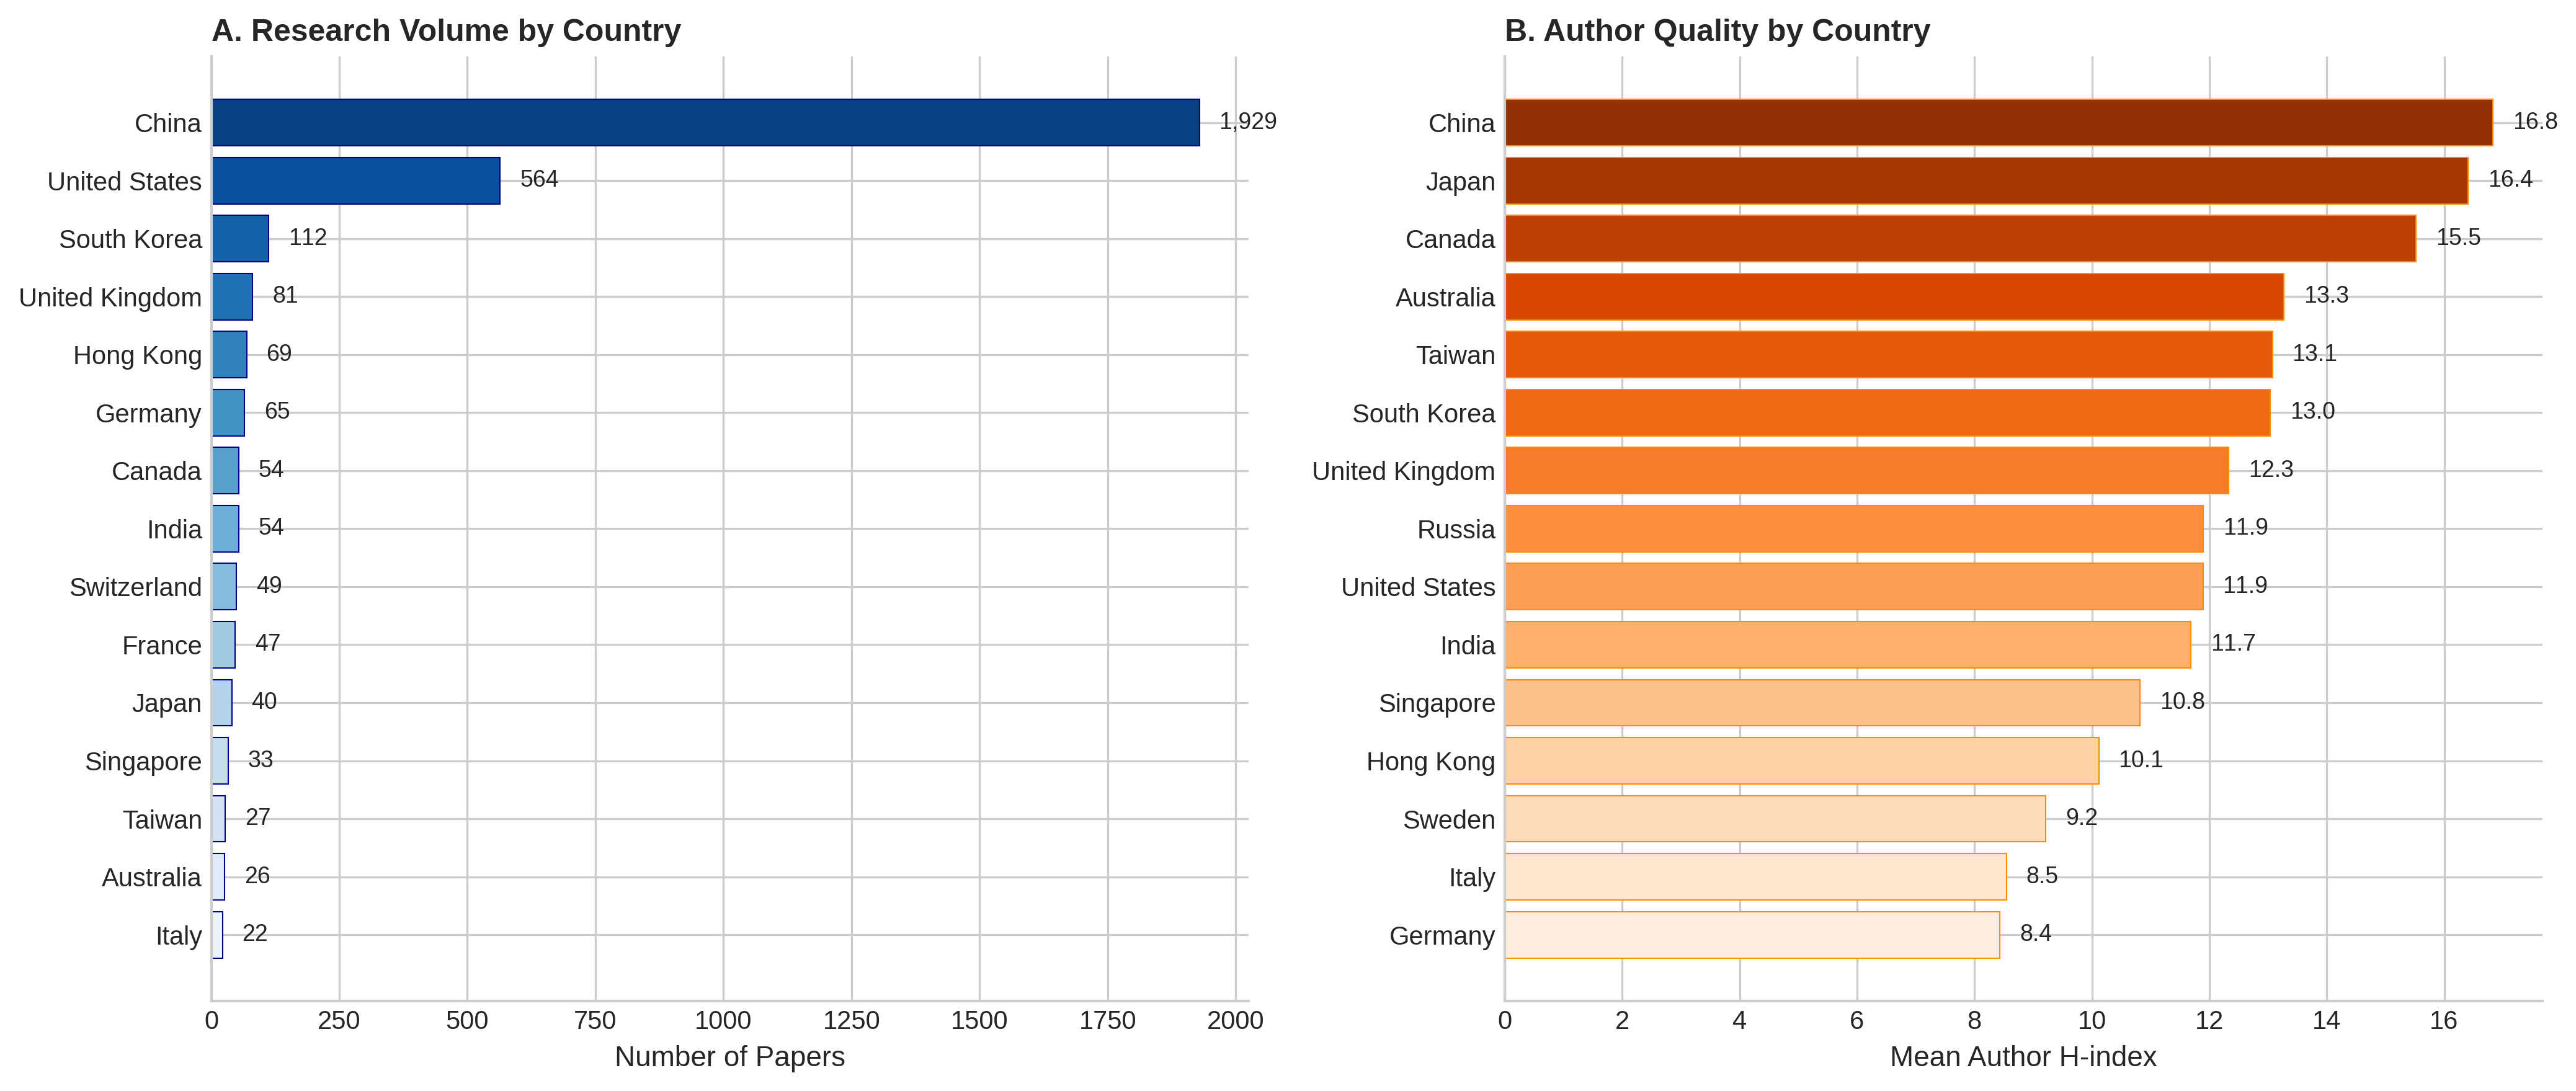

In [19]:
# Install plotly if needed (for interactive maps)
!pip install -q plotly kaleido

# Generate professional country analysis
from arxiv_integration import create_country_analysis, generate_statistical_summary

# Output directory - use last_results/arxiv_author for organized results
OUTPUT_DIR = f'/content/{REPO_NAME}/last_results/arxiv_author'
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(f'{OUTPUT_DIR}/figures', exist_ok=True)
os.makedirs(f'{OUTPUT_DIR}/tables', exist_ok=True)

print("Generating country analysis visualizations...")
print("=" * 60)

# Create all visualizations
viz_results = create_country_analysis(
    enriched_df,
    output_dir=OUTPUT_DIR,
    min_papers=10,
    top_n=15,
    save_formats=['png', 'pdf']
)

print(f"\nFigures saved to: {OUTPUT_DIR}")
print("  - country_analysis_bars.png (bar charts)")
print("  - country_map_quality.png (h-index world map)")
print("  - country_map_volume.png (volume world map)")
print("  - country_analysis_summary.png (4-panel summary)")

# Display the bar chart
from IPython.display import Image, display
display(Image(filename=f'{OUTPUT_DIR}/country_analysis_bars.png'))

World Map - Author Quality (Mean H-index)


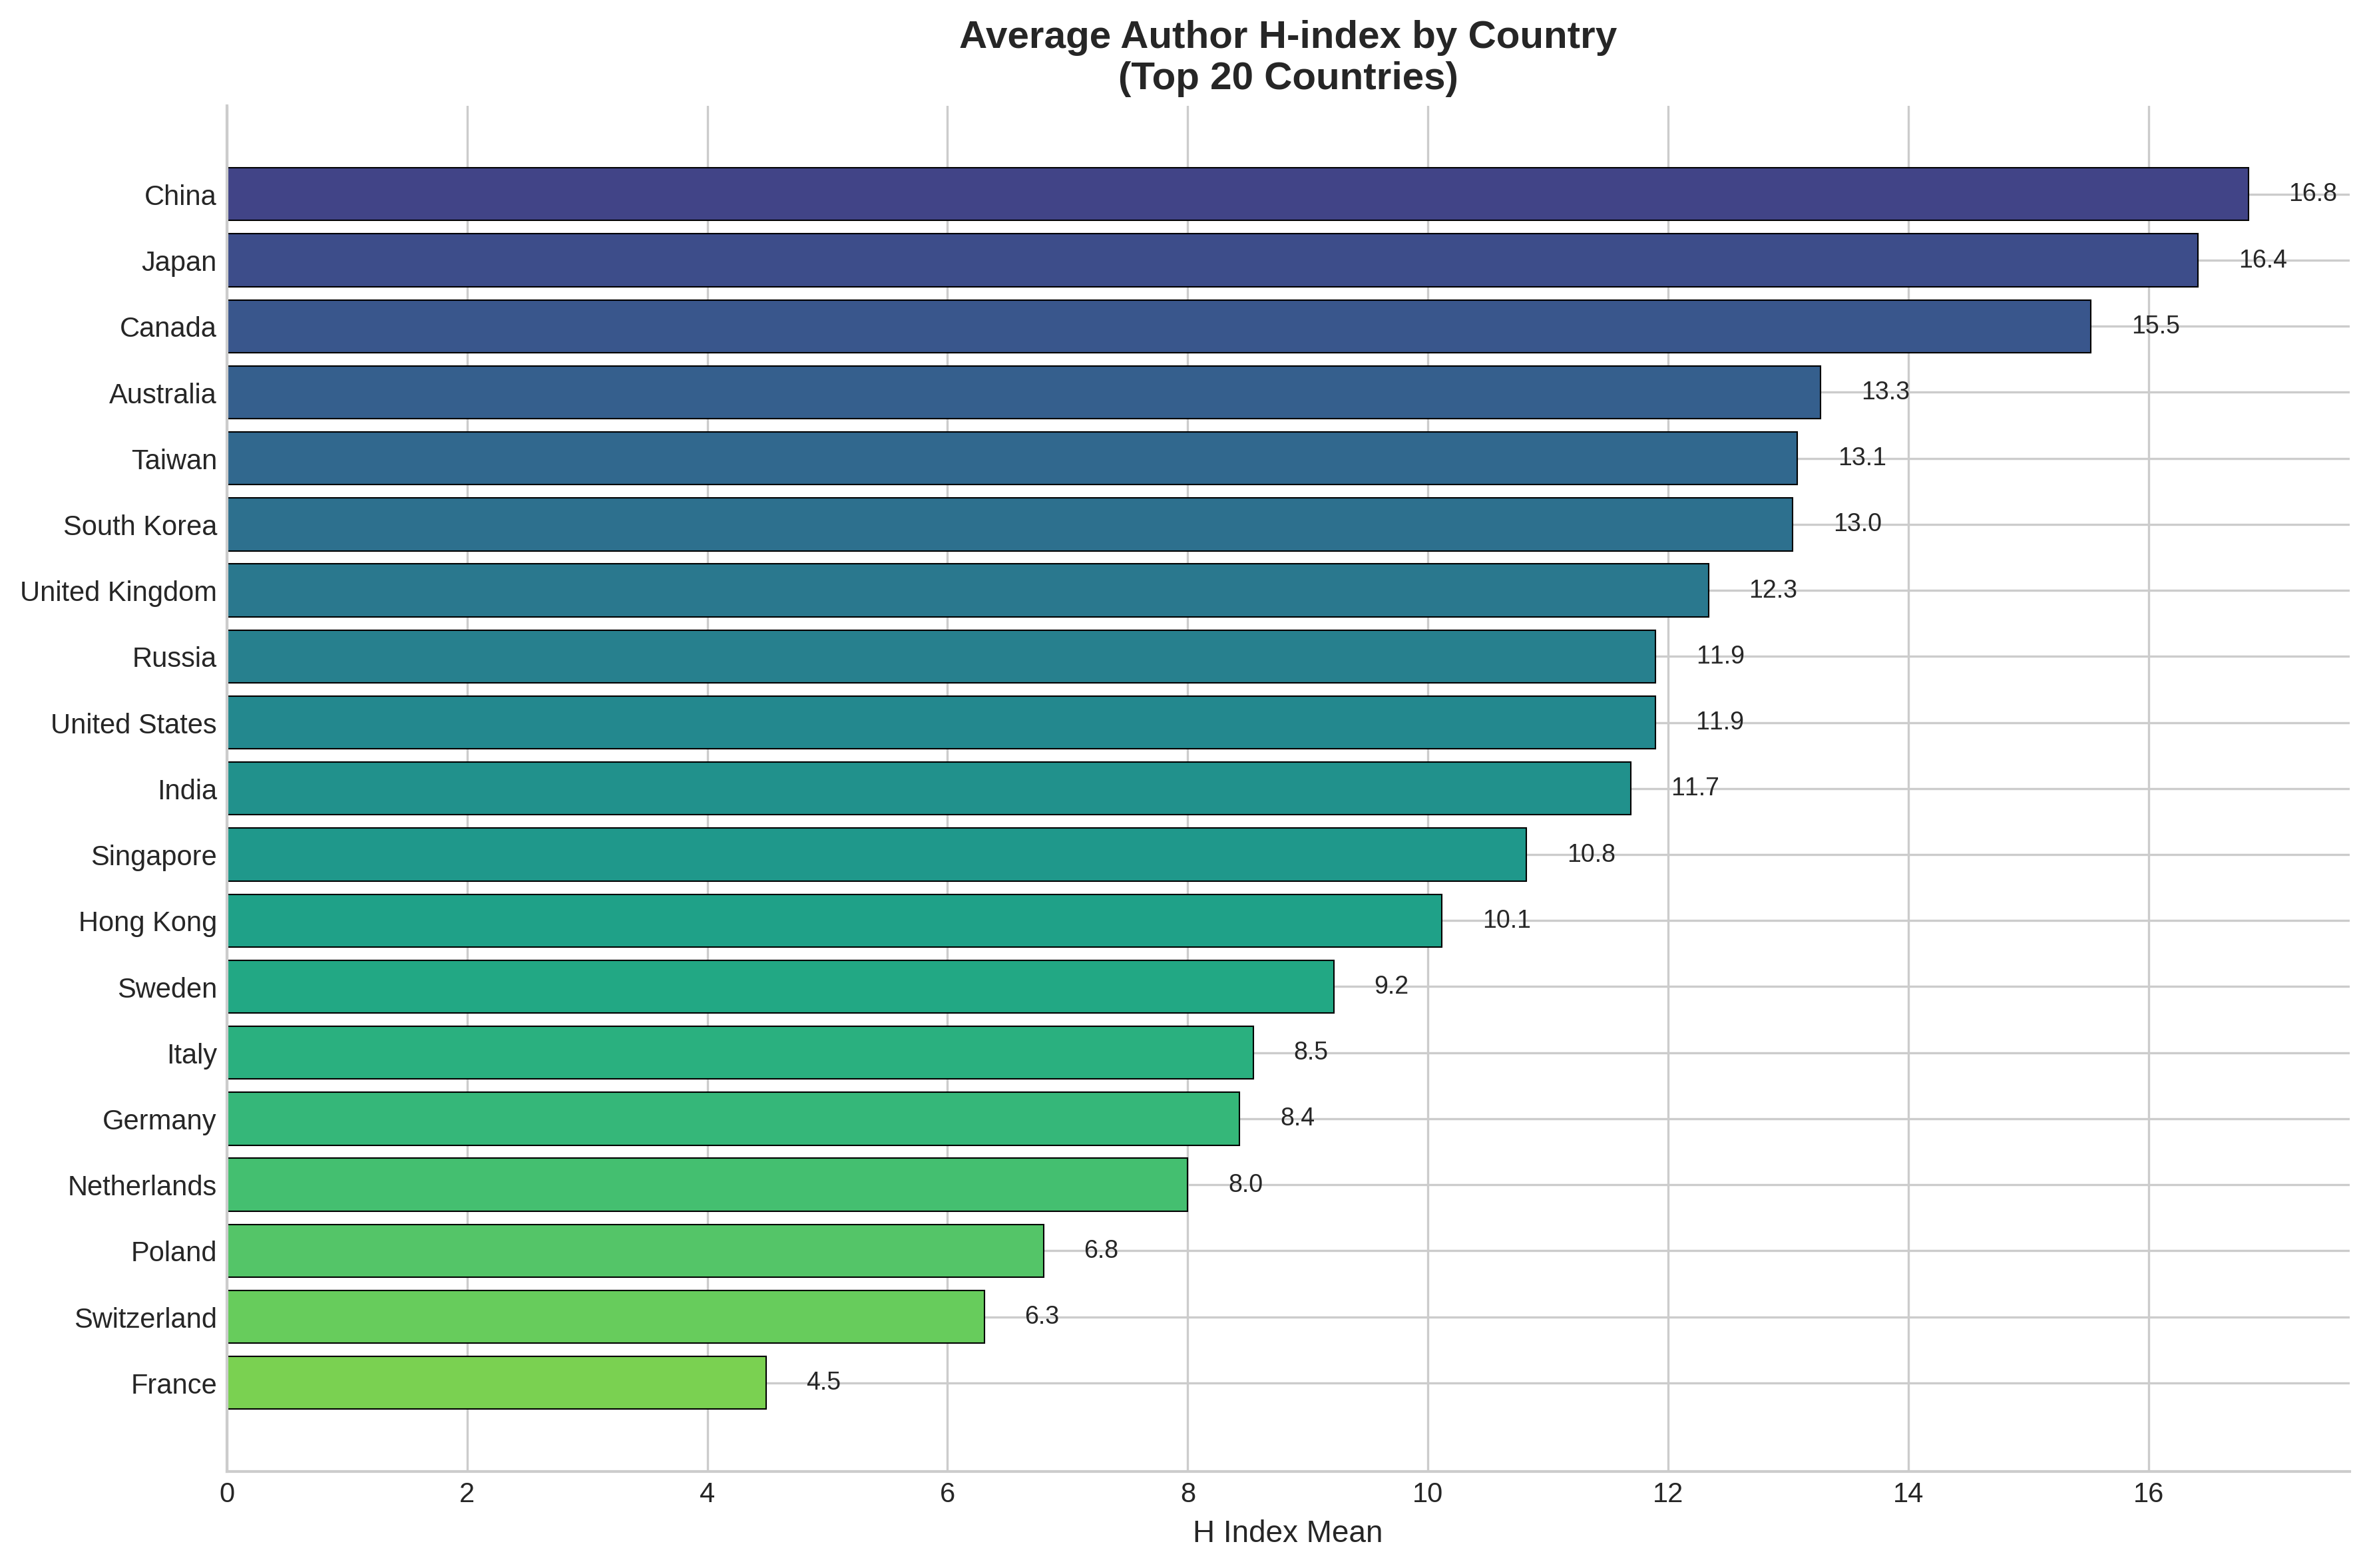


World Map - Research Volume (Paper Count)


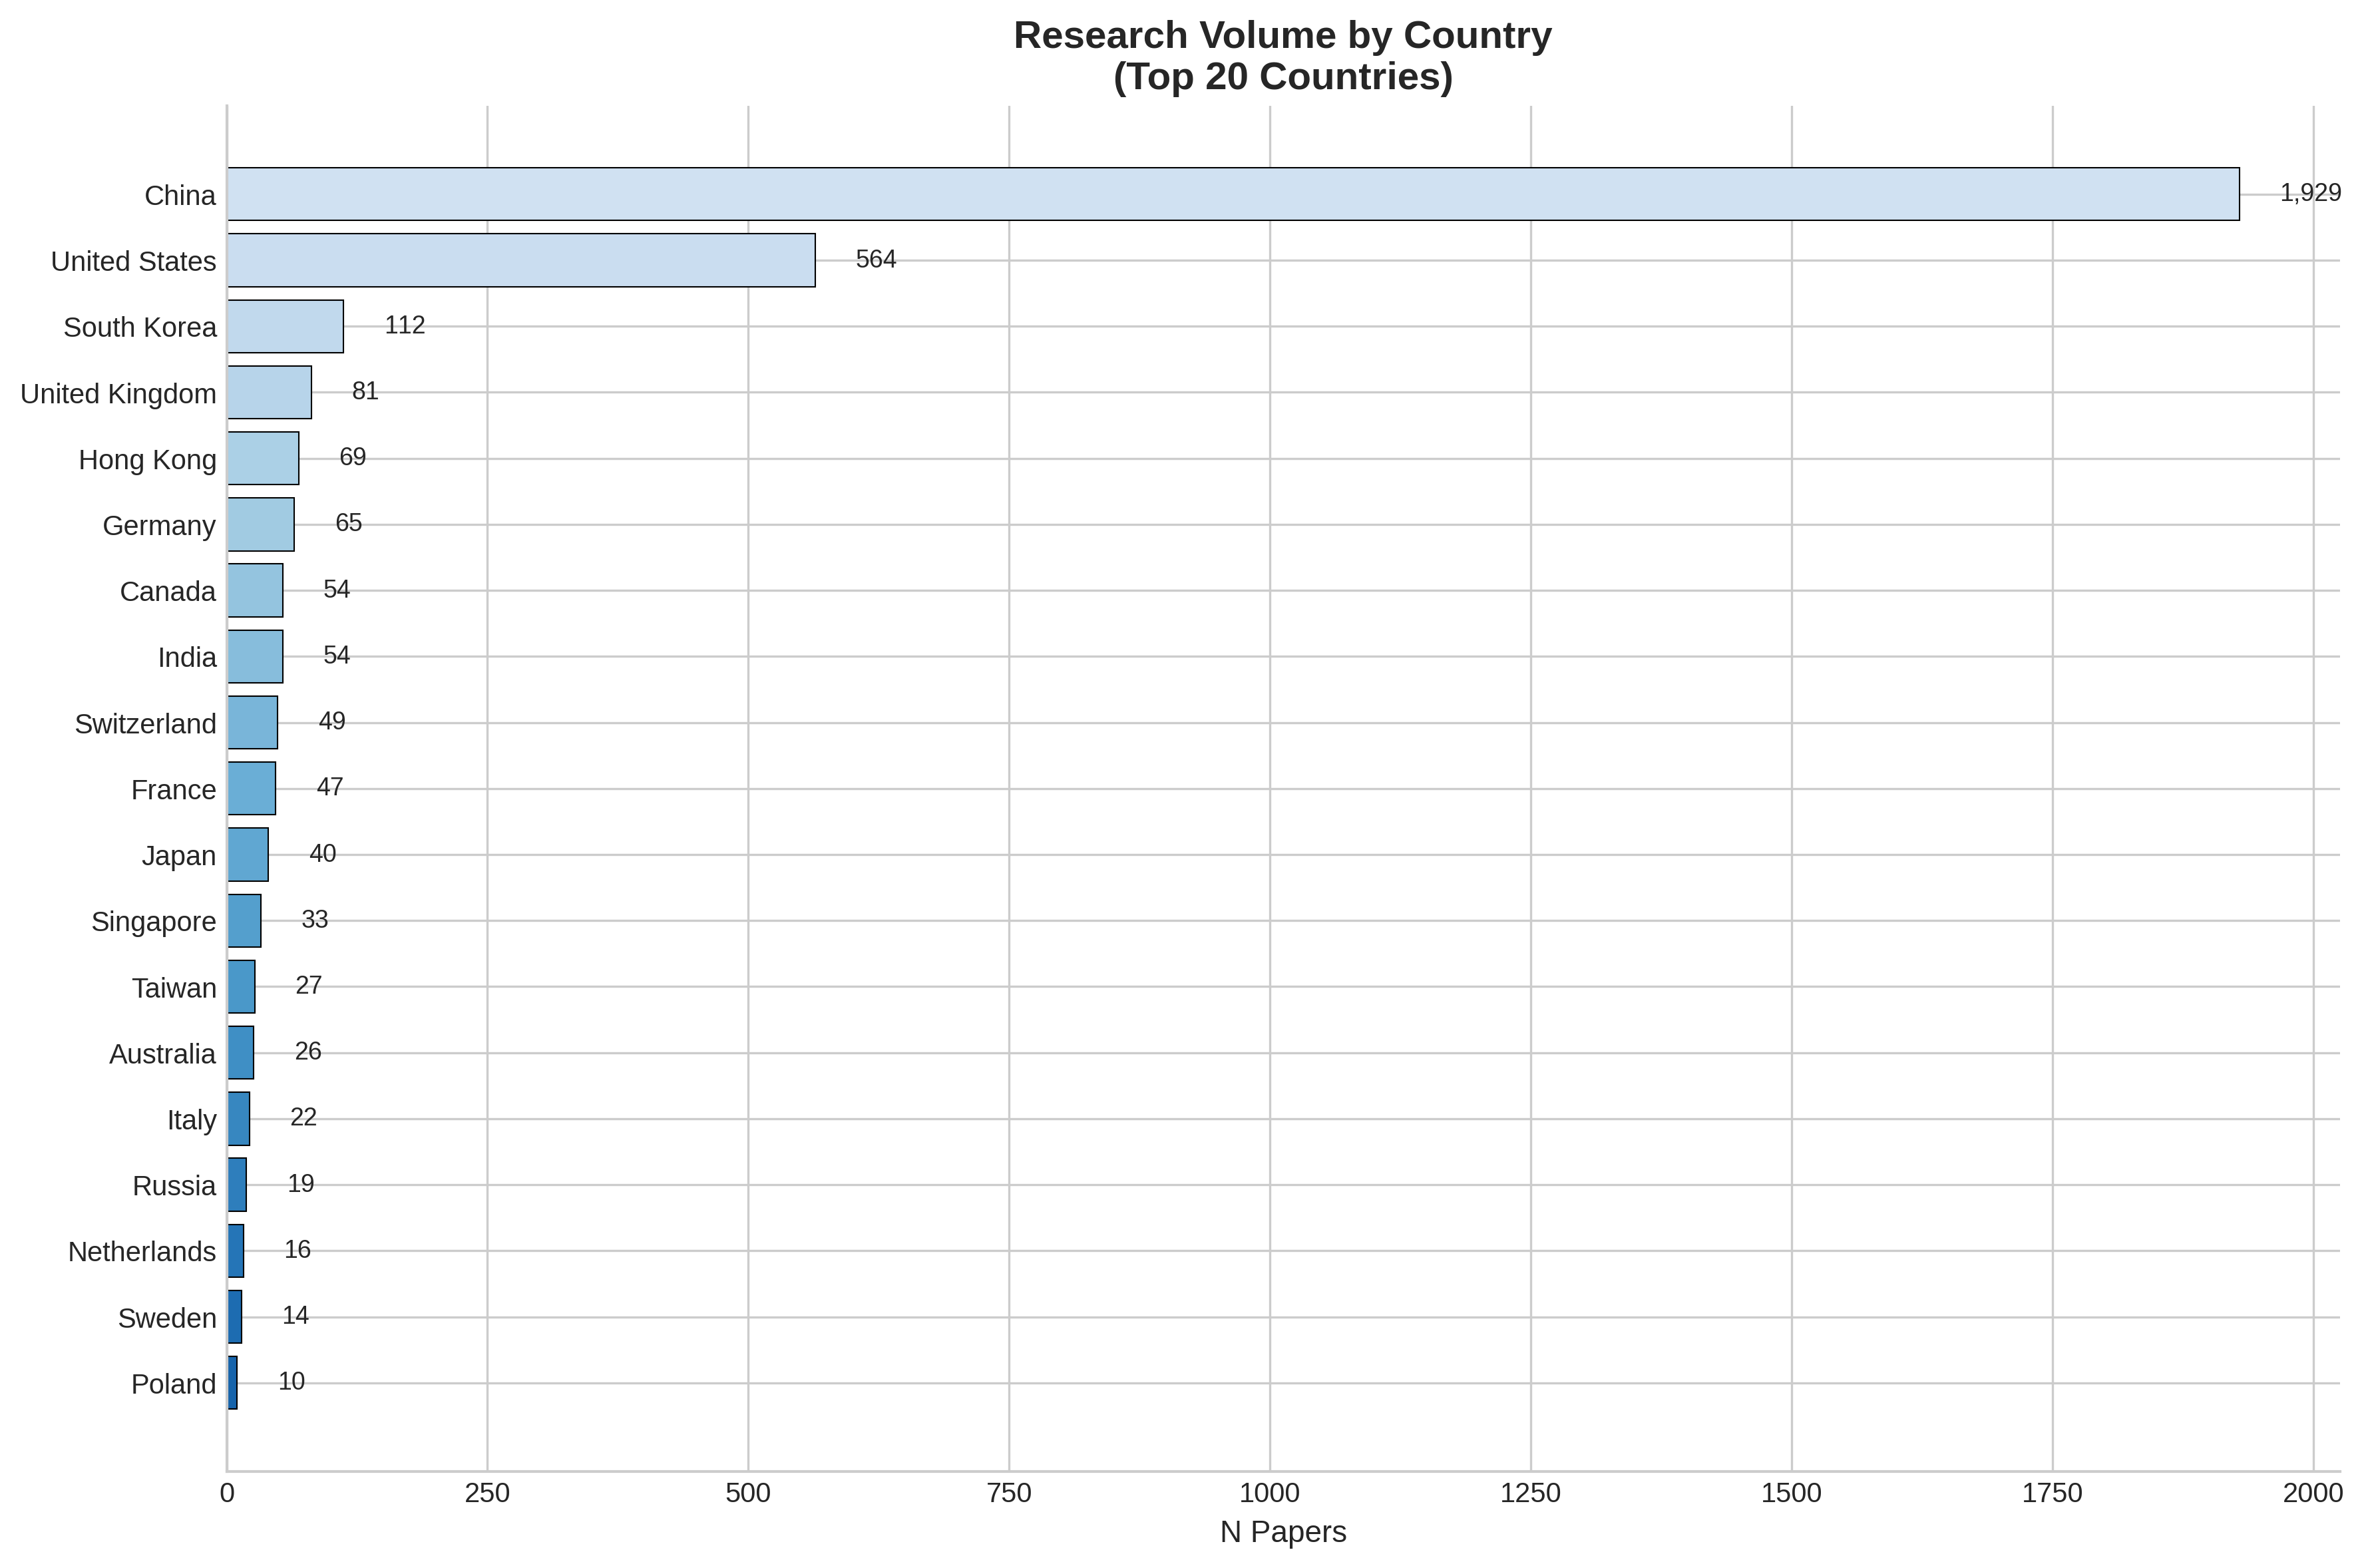

In [20]:
# Display world maps - with HTML fallback if PNG doesn't exist
from IPython.display import Image, IFrame, display, HTML
import os

print("World Map - Author Quality (Mean H-index)")
print("=" * 60)

# Try PNG first, fall back to HTML for interactive display
quality_png = f'{OUTPUT_DIR}/country_map_quality.png'
quality_html = f'{OUTPUT_DIR}/country_map_quality.html'

if os.path.exists(quality_png) and os.path.getsize(quality_png) > 0:
    display(Image(filename=quality_png))
elif os.path.exists(quality_html):
    print("  (Displaying interactive HTML map - PNG export not available)")
    display(IFrame(src=quality_html, width=900, height=500))
else:
    print("  ⚠️ Quality map not found")

print("\nWorld Map - Research Volume (Paper Count)")
print("=" * 60)

volume_png = f'{OUTPUT_DIR}/country_map_volume.png'
volume_html = f'{OUTPUT_DIR}/country_map_volume.html'

if os.path.exists(volume_png) and os.path.getsize(volume_png) > 0:
    display(Image(filename=volume_png))
elif os.path.exists(volume_html):
    print("  (Displaying interactive HTML map - PNG export not available)")
    display(IFrame(src=volume_html, width=900, height=500))
else:
    print("  ⚠️ Volume map not found")

Comprehensive Country Analysis Summary


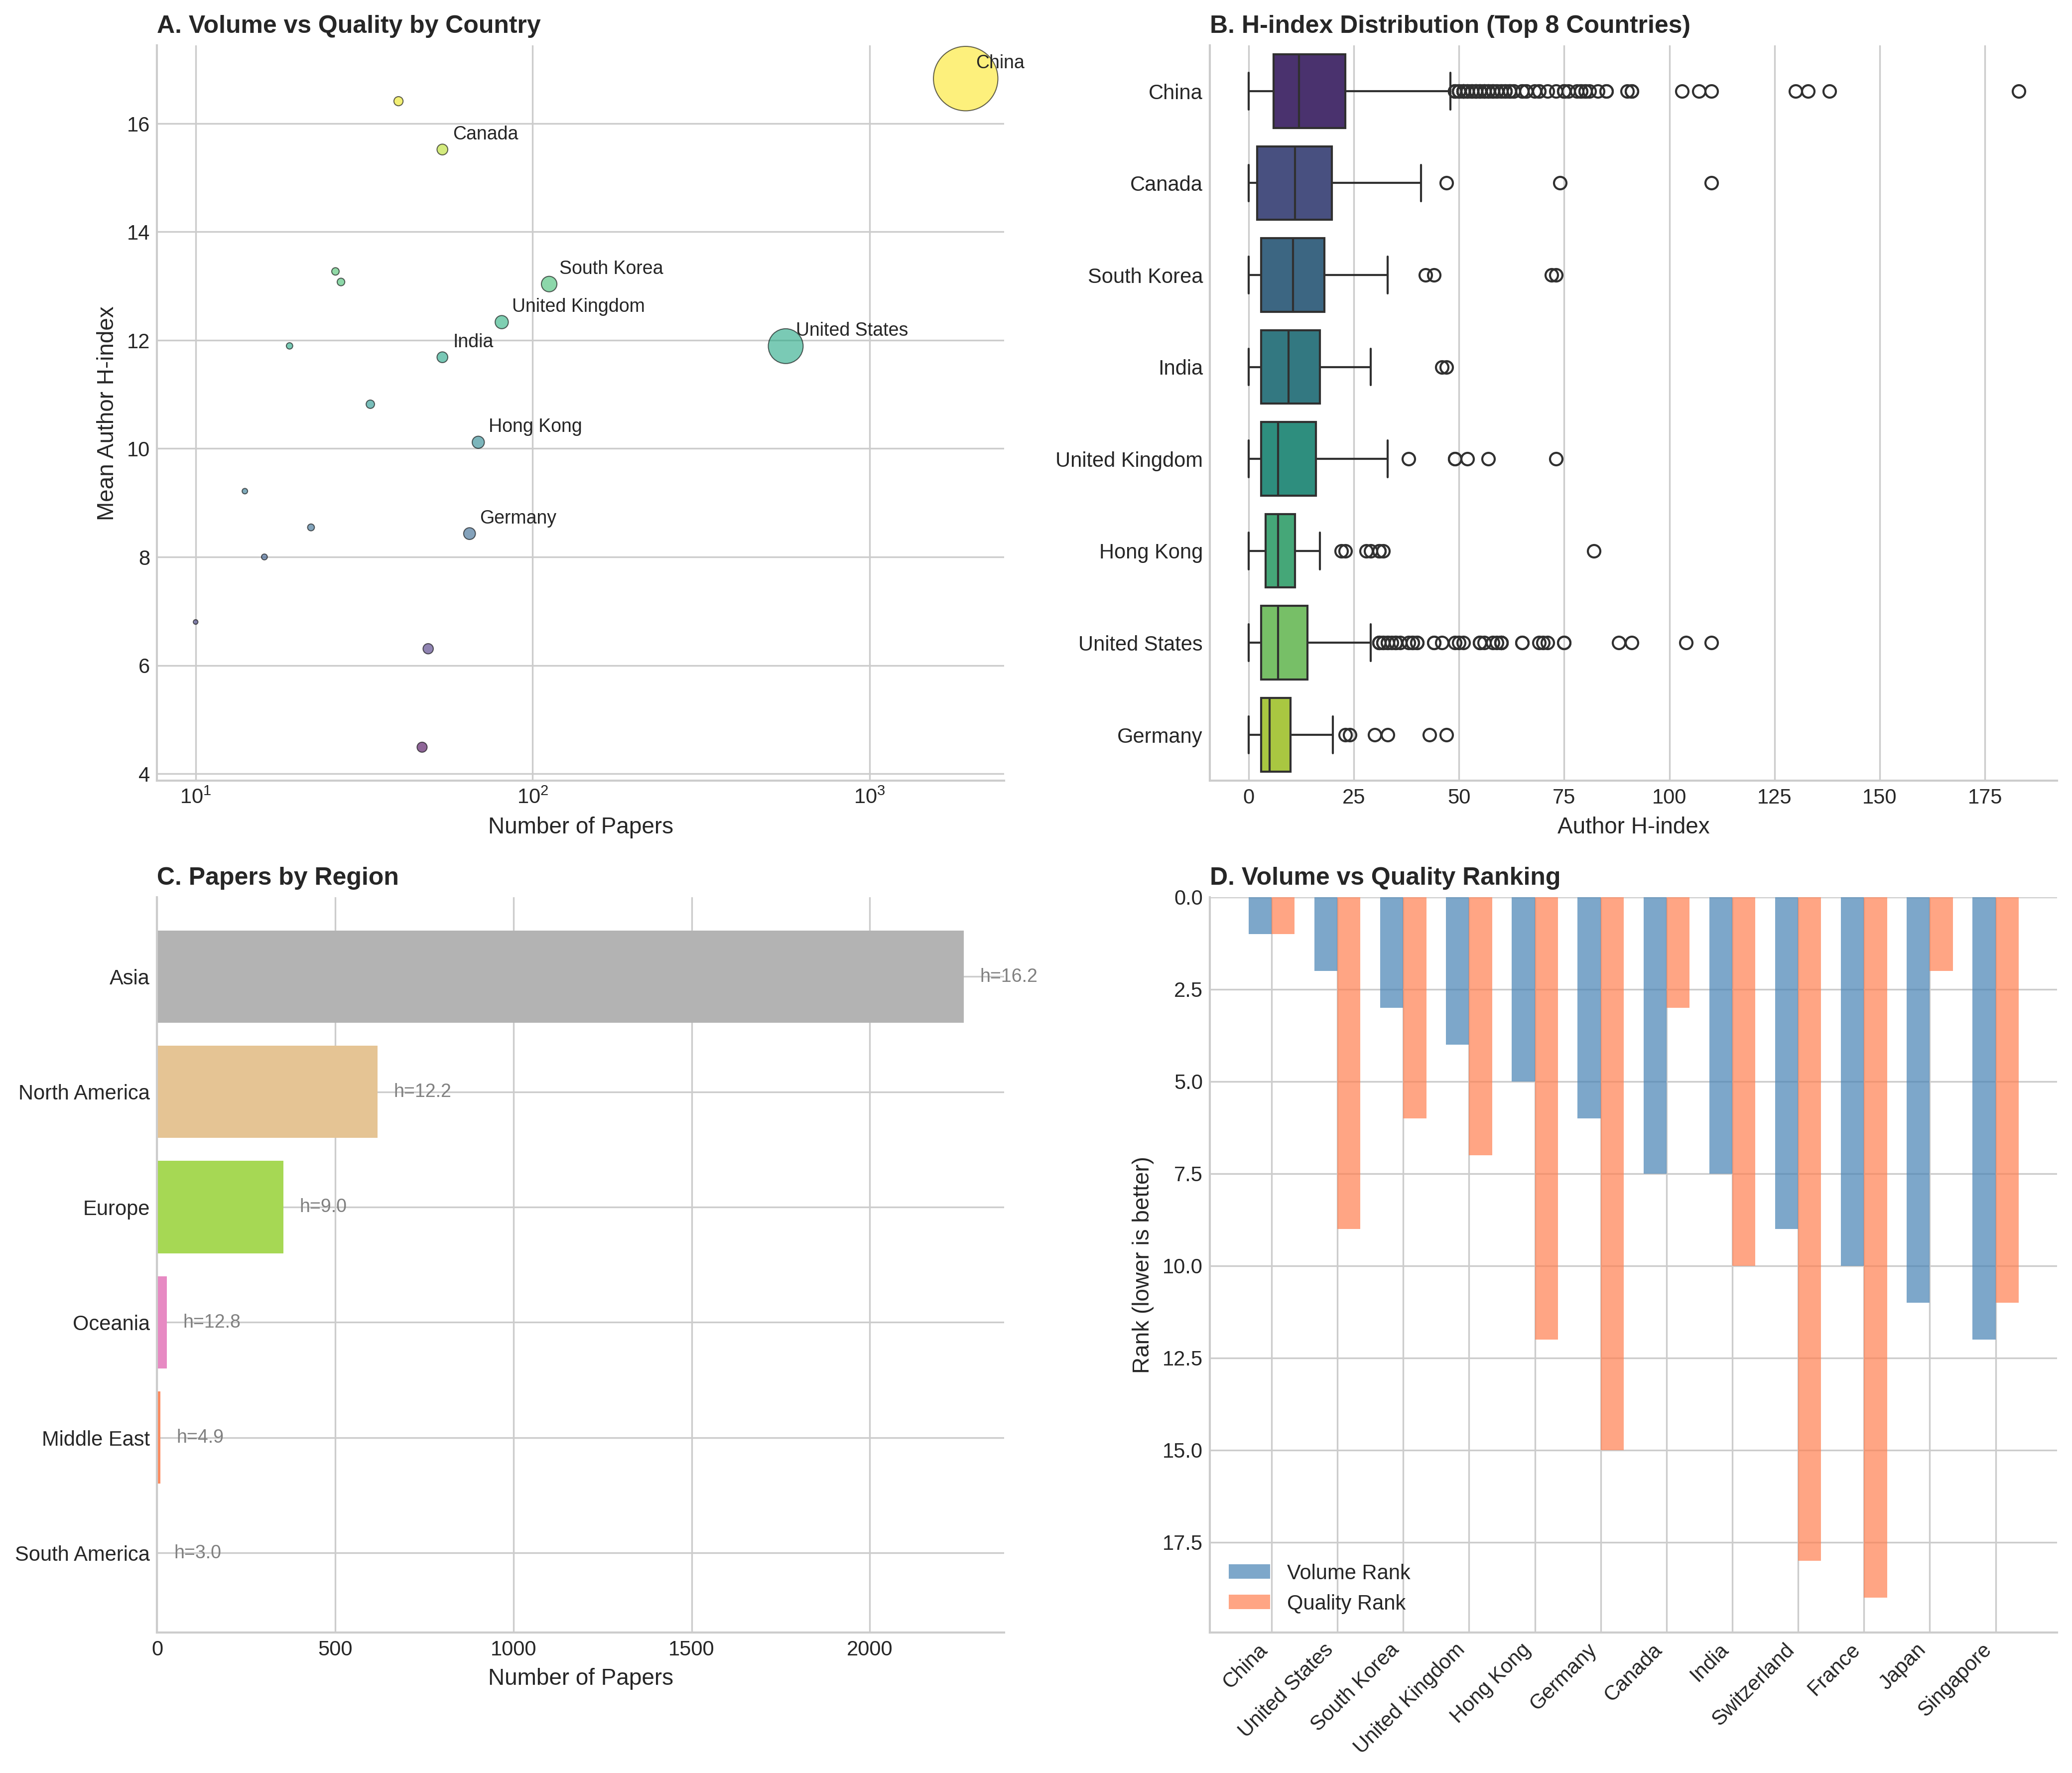




# Geographic Analysis of ICLR Submissions

## Data Coverage
- **Total papers**: 19,381
- **With country data**: 3,275 (16.9%)
- **With h-index data**: 6,476 (33.4%)

## Key Findings

### 1. Research Volume (Where papers come from)
Top 5 countries by paper volume:
   1. **China**: 1,929 papers (58.9%)
   2. **United States**: 564 papers (17.2%)
   3. **South Korea**: 112 papers (3.4%)
   4. **United Kingdom**: 81 papers (2.5%)
   5. **Hong Kong**: 69 papers (2.1%)

### 2. Research Quality (Author expertise)
Top 5 countries by average author h-index (min 10 papers):
   1. **China**: mean h-index = 16.8 (n=1929)
   2. **Japan**: mean h-index = 16.4 (n=39)
   3. **Canada**: mean h-index = 15.5 (n=54)
   4. **Australia**: mean h-index = 13.3 (n=26)
   5. **Taiwan**: mean h-index = 13.1 (n=27)

### 3. Volume vs Quality Comparison

**China vs United States:**
- China: #1 by volume, mean h-index = 16.8
- United States: #2 by volume, mean h-index = 11.9

**Interpretation**: China leads in bo

In [21]:
# Display 4-panel summary figure
print("Comprehensive Country Analysis Summary")
print("=" * 60)
display(Image(filename=f'{OUTPUT_DIR}/country_analysis_summary.png'))

# Generate and display statistical summary
print("\n")
summary_text = generate_statistical_summary(enriched_df, output_dir=OUTPUT_DIR)
print(summary_text)

## 5. Reviewer Robustness Tests (Restud)

This section addresses two key referee concerns:

### Test 1: Adverse Selection / Effort Endogeneity
> "The negative coefficient on AI likely captures 'low researcher effort' rather than 'substitution of judgment'."

We address this with:
- **Oster (2019) bounds**: How much unobserved selection would need to exist to explain away the result?
- **AI Fingerprint**: Does Soundness decline more than Presentation? (Laziness affects both; AI substitution affects judgment only)

### Test 2: Detector Bias Confound
> "AI detectors may flag non-native English speakers at higher rates, creating spurious correlation."

We test if the AI penalty holds for both:
- Native English speakers (US, UK, Canada, Australia)
- Non-native English speakers

In [22]:
# Run comprehensive reviewer robustness tests
from arxiv_integration.analysis.reviewer_robustness_tests import (
    run_reviewer_robustness_tests,
    generate_robustness_latex_table,
    export_all_results
)

# Run all tests
reviewer_results = run_reviewer_robustness_tests(
    reviews_df=reviews_df,
    submissions_df=submissions_df,
    enriched_df=enriched_df,
    verbose=True,
    save_results=True,
    output_dir=OUTPUT_DIR
)

# Export comprehensive results (summary, detailed, LaTeX, report)
export_paths = export_all_results(
    reviewer_results,
    output_dir=OUTPUT_DIR,
    prefix='reviewer_robustness'
)

print("\n" + "=" * 70)
print("RESULTS EXPORTED")
print("=" * 70)
for name, path in export_paths.items():
    print(f"  {name}: {path}")

# Generate LaTeX table for paper
latex_table = generate_robustness_latex_table(reviewer_results)
print("\n" + "=" * 70)
print("LATEX TABLE FOR PAPER")
print("=" * 70)
print(latex_table)

# Save LaTeX to output directory
with open(f'{OUTPUT_DIR}/reviewer_robustness_table.tex', 'w') as f:
    f.write(latex_table)
print(f"\nSaved to: {OUTPUT_DIR}/reviewer_robustness_table.tex")


RESTUD REVIEWER ROBUSTNESS TESTS

Addressing two key referee concerns:
1. Adverse Selection / Effort Endogeneity
2. AI Detector Bias Against Non-Native Speakers


TEST 1: OSTER BOUNDS (Effort Endogeneity)

OSTER (2019) BOUNDS FOR UNOBSERVED SELECTION
Testing: How much 'effort' confounding would explain away AI effect?

Uncontrolled model:
  β(AI) = -0.2308, R² = 0.0409

Controlled model (with h-index):
  β(AI) = -0.2301, R² = 0.0427

Oster's δ (selection ratio): 2543.78
Bias-adjusted β*: -0.2252
Identified set: [-0.2301, -0.2252]

ROBUST TO SELECTION: δ = 2543.78 > 1
Selection on unobservables would need to be 2543.8x stronger than
selection on observables to explain away the result.
This is implausible under standard assumptions (Oster, 2019).


TEST 2: AI FINGERPRINT (Soundness vs Presentation)

AI FINGERPRINT TEST: Soundness vs Presentation Differential
Testing: Does Soundness (judgment) decline more than Presentation (polish)?

AI Papers (>=20.0% AI): 19,929 reviews
Human Papers (

In [23]:
# Run selection robustness analysis
# (imports are fixed to work from notebook context)
from arxiv_integration.analysis.selection_robustness import run_selection_robustness_analysis

# Run full analysis
results = run_selection_robustness_analysis(
    reviews_df=reviews_df,
    submissions_df=submissions_df,
    enriched_df=enriched_df,
    components=['soundness', 'presentation', 'contribution'],
    verbose=True,
    save_tables=True,
    output_dir=OUTPUT_DIR
)


SELECTION ROBUSTNESS ANALYSIS
Addressing referee critique: Selection vs Treatment

Statistical Methods:
  - Clustered SEs by paper (accounts for multiple reviews)
  - FDR correction for multiple testing
  - Bootstrap CIs (2000 iterations)
  - Winsorized h-index (1% tails)

1. Merging author reputation data...
   Input: 19381 submissions, 19381 enriched records
   Merged rows: 75800 (reviews × submissions)
   Unique papers with h-index: 6458 / 19381 (33.3%)

   Reputation tier distribution:
reputation_tier
Emerging       8381
Established    8381
Senior         8381
dtype: int64

2. Running stratified analysis...

STRATIFIED ANALYSIS: RATING
Clustering standard errors by: submission_number

Emerging (n=8381, clusters=2439):
  AI-Human difference: -0.6772 [-0.8455, -0.4999]
  p-value (Mann-Whitney): 0.0000
  p-value (OLS clustered): 0.0000
  Effect size (Cohen's d): -0.361

Established (n=8381, clusters=2487):
  AI-Human difference: -0.8311 [-1.0048, -0.6414]
  p-value (Mann-Whitney): 0.

In [24]:
# Display summary table
print("\n" + "="*70)
print("SELECTION ROBUSTNESS TABLE")
print("="*70)
results['summary_table']


SELECTION ROBUSTNESS TABLE


Panel                    Stratum Estimate  \
0     A. Stratified by Author Reputation                                       
1                                                          Emerging  -0.6772   
2                                                       Established  -0.8311   
3                                                            Senior  -0.5494   
4   B. Interaction Model (Clustered SEs)                                       
5                                                     AI percentage  -0.2769   
6                                                           H-index   0.0254   
7                                                      AI × H-index   0.0546   
8     C. Component Effects by Reputation                                       
9                                               Emerging: soundness    -8.6%   
10                                           Emerging: presentation    -9.0%   
11                                           Emerging: contribution    -5.9%   
12                                                Senior: soundness    -6.6%   
13                                             Senior: presentation    -6.4%   
14                                             Senior: contribution    -6.4%   
15                                           Established: soundness   -10.2%   
16                                        Established: presentation   -10.0%   
17                                        Established: contribution    -7.5%   

        SE p-value   p-FDR     N  
0                                 
1   0.1035  0.0000  0.0000  8381  
2   0.1077  0.0000  0.0000  8381  
3   0.1115  0.0000  0.0000  8381  
4                                 
5   0.0168  0.0000          6458  
6   0.0133  0.0568          6458  
7   0.0166  0.0010          6458  
8                                 
9           0.0000                
10          0.0000                
11          0.0000                
12          0.0000                
13          0.0000                
14          0.0000                
15          0.0000                
16          0.0000                
17          0.0000

## 6. Visualizations for Publication

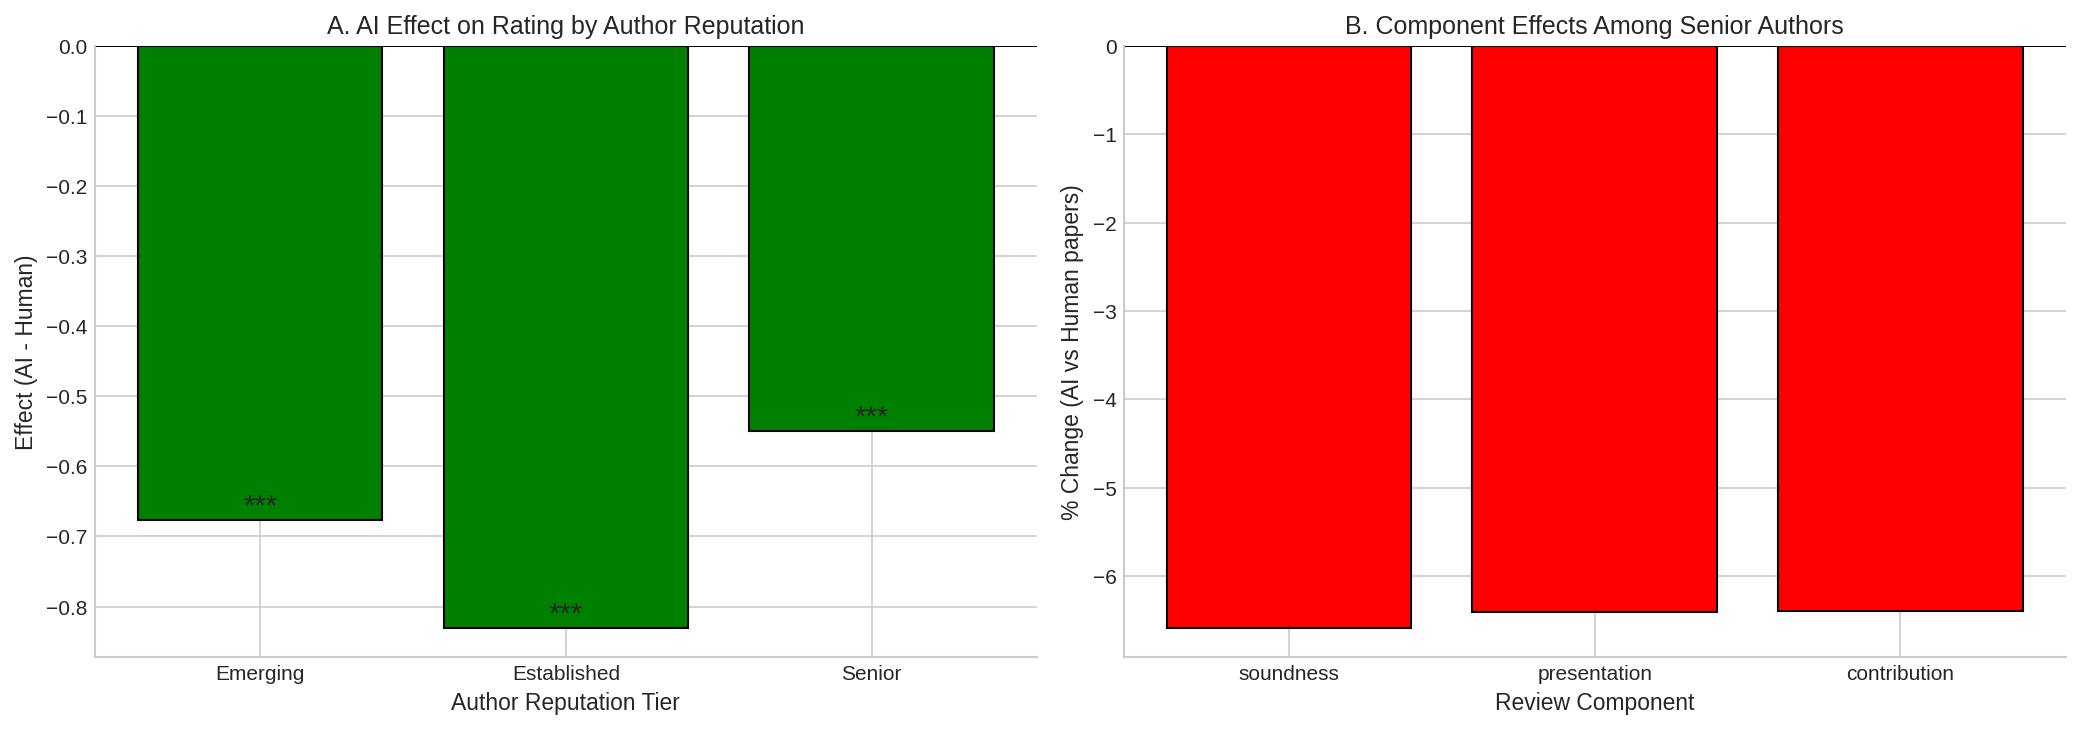


✓ Figure saved as /content/HAI-Frontier/last_results/arxiv_author/selection_robustness_figure.png


In [25]:
# Effect by reputation tier visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel A: Effect size by reputation tier
stratified = results.get('stratified', {}).get('by_stratum', {})
if stratified:
    tiers = list(stratified.keys())
    effects = [stratified[t].get('interaction', stratified[t].get('mean_diff', 0)) for t in tiers]
    pvals = [stratified[t].get('p_interaction', stratified[t].get('p_value', 1)) for t in tiers]

    colors = ['green' if p < 0.05 else 'gray' for p in pvals]
    bars = axes[0].bar(tiers, effects, color=colors, edgecolor='black')
    axes[0].axhline(0, color='black', linestyle='-', linewidth=0.5)
    axes[0].set_xlabel('Author Reputation Tier')
    axes[0].set_ylabel('Effect (AI - Human)')
    axes[0].set_title('A. AI Effect on Rating by Author Reputation')

    # Add significance markers
    for i, (bar, p) in enumerate(zip(bars, pvals)):
        if p < 0.001:
            sig = '***'
        elif p < 0.01:
            sig = '**'
        elif p < 0.05:
            sig = '*'
        else:
            sig = ''
        if sig:
            axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height(), sig,
                        ha='center', va='bottom', fontsize=14)

# Panel B: Component effects
components = results.get('components', {}).get('by_stratum', {})
if components and 'Senior' in components:
    senior_comps = components['Senior']
    comp_names = list(senior_comps.keys())
    comp_effects = [senior_comps[c]['pct_diff'] for c in comp_names]
    comp_pvals = [senior_comps[c]['p_value'] for c in comp_names]

    colors = ['red' if p < 0.05 else 'gray' for p in comp_pvals]
    bars = axes[1].bar(comp_names, comp_effects, color=colors, edgecolor='black')
    axes[1].axhline(0, color='black', linestyle='-', linewidth=0.5)
    axes[1].set_xlabel('Review Component')
    axes[1].set_ylabel('% Change (AI vs Human papers)')
    axes[1].set_title('B. Component Effects Among Senior Authors')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/selection_robustness_figure.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Figure saved as {OUTPUT_DIR}/selection_robustness_figure.png")

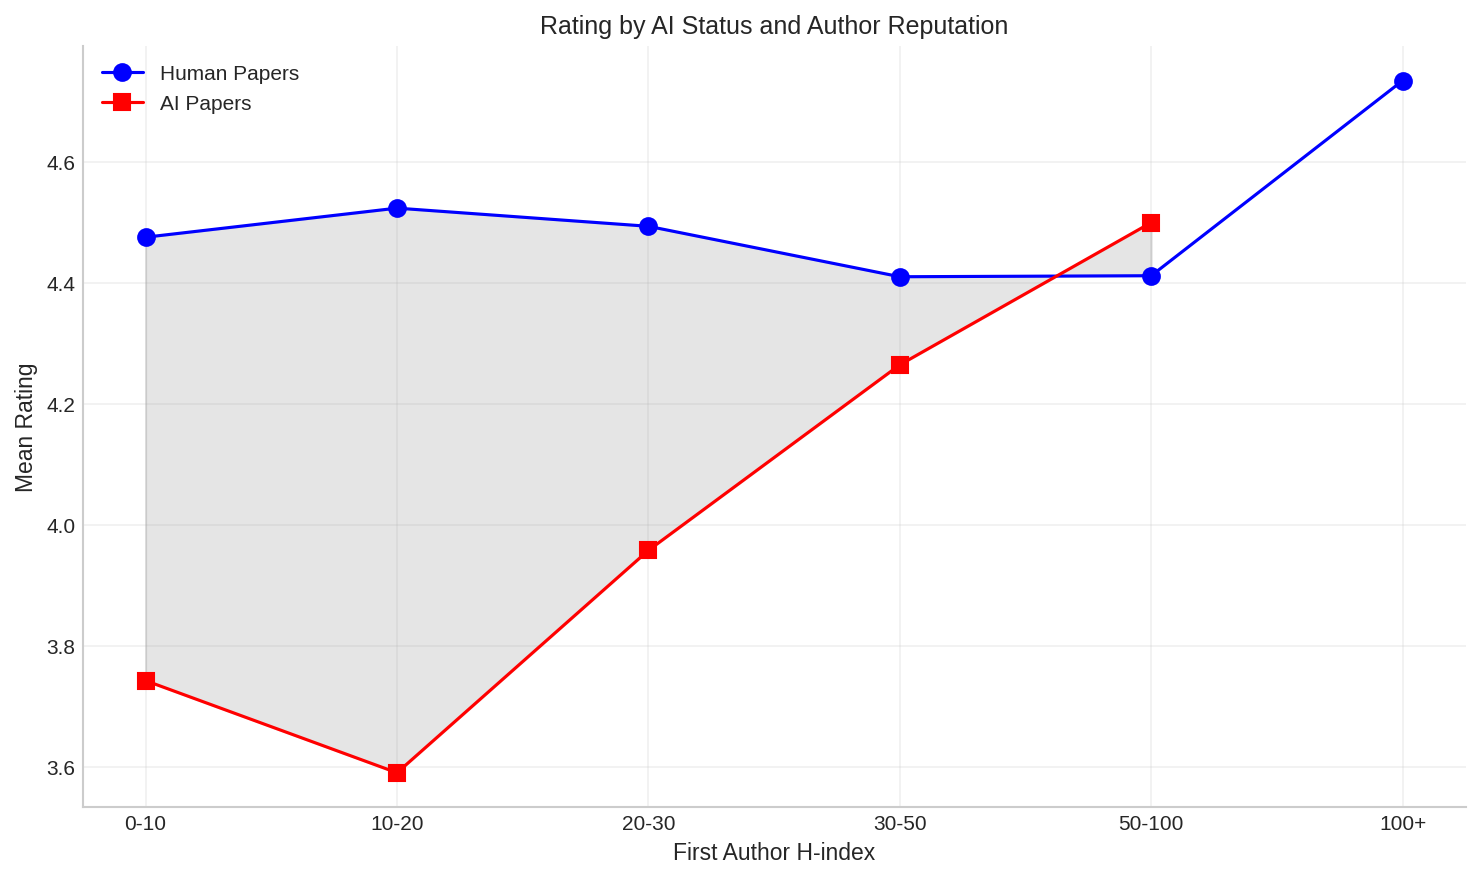


✓ Figure saved as /content/HAI-Frontier/last_results/arxiv_author/interaction_plot.png


In [26]:
# Interaction plot
from arxiv_integration.analysis.selection_robustness import merge_author_data, create_analysis_variables

# Prepare data
merged = merge_author_data(reviews_df, submissions_df, enriched_df)
merged = create_analysis_variables(merged)

# Create h-index bins
merged['h_index_bin'] = pd.cut(
    merged['first_author_h_index'],
    bins=[0, 10, 20, 30, 50, 100, 500],
    labels=['0-10', '10-20', '20-30', '30-50', '50-100', '100+']
)

# Calculate mean rating by AI status and h-index bin
interaction_data = merged.groupby(['h_index_bin', 'paper_AI'])['rating'].mean().unstack()

fig, ax = plt.subplots(figsize=(10, 6))

if 0 in interaction_data.columns and 1 in interaction_data.columns:
    x = range(len(interaction_data.index))
    ax.plot(x, interaction_data[0], 'b-o', label='Human Papers', markersize=8)
    ax.plot(x, interaction_data[1], 'r-s', label='AI Papers', markersize=8)
    ax.fill_between(x, interaction_data[0], interaction_data[1], alpha=0.2, color='gray')

    ax.set_xticks(x)
    ax.set_xticklabels(interaction_data.index)
    ax.set_xlabel('First Author H-index')
    ax.set_ylabel('Mean Rating')
    ax.set_title('Rating by AI Status and Author Reputation')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/interaction_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Figure saved as {OUTPUT_DIR}/interaction_plot.png")

## 6.1 Extended Interaction Analysis: Components × H-index Measures

This section analyzes whether author experience moderates the AI effect differently for:
- **Soundness** (intellectual judgment) vs **Presentation** (surface polish)
- **First author** (often junior, does the work) vs **Last author** (senior, provides supervision)
- **Mean h-index** (team average expertise)


FULL INTERACTION ANALYSIS
Components × H-index Measures

1. Running component × h-index interaction models...

COMPONENT × H-INDEX INTERACTION ANALYSIS

Does author experience moderate the AI effect differently
for Soundness (judgment) vs Presentation (polish)?

──────────────────────────────────────────────────────────────────────
COMPONENT: SOUNDNESS
──────────────────────────────────────────────────────────────────────

  first author:
    AI effect:     β = -0.0903 (p = 0.0000)
    Interaction:   β = +0.0129 (p = 0.0282) *
    → High first author authors show LESS negative AI effect

  last author:
    AI effect:     β = -0.0897 (p = 0.0000)
    Interaction:   β = +0.0047 (p = 0.4657) 

  mean author:
    AI effect:     β = -0.0897 (p = 0.0000)
    Interaction:   β = +0.0090 (p = 0.1303) 

──────────────────────────────────────────────────────────────────────
COMPONENT: PRESENTATION
──────────────────────────────────────────────────────────────────────

  first author:
    AI effe

component h_index_measure   ai_coef          ai_p  interaction_coef  \
0     soundness           first -0.090284  5.785780e-50          0.012932   
1     soundness            last -0.089690  3.058252e-40          0.004700   
2     soundness            mean -0.089653  8.230530e-50          0.009035   
3  presentation           first -0.074577  3.260631e-32          0.017931   
4  presentation            last -0.071480  1.518428e-24          0.010286   
5  presentation            mean -0.073758  3.064109e-32          0.016198   
6  contribution           first -0.065982  2.867297e-28          0.006444   
7  contribution            last -0.067422  1.603277e-24         -0.006655   
8  contribution            mean -0.066216  1.100130e-28         -0.002361   

   interaction_se  interaction_p  significant      n  
0        0.005892       0.028182         True  25143  
1        0.006442       0.465669        False  20405  
2        0.005972       0.130306        False  25146  
3        0.006420       0.005221         True  25143  
4        0.006624       0.120466        False  20405  
5        0.006060       0.007515         True  25146  
6        0.005974       0.280672        False  25143  
7        0.006553       0.309894        False  20405  
8        0.005846       0.686240        False  25146

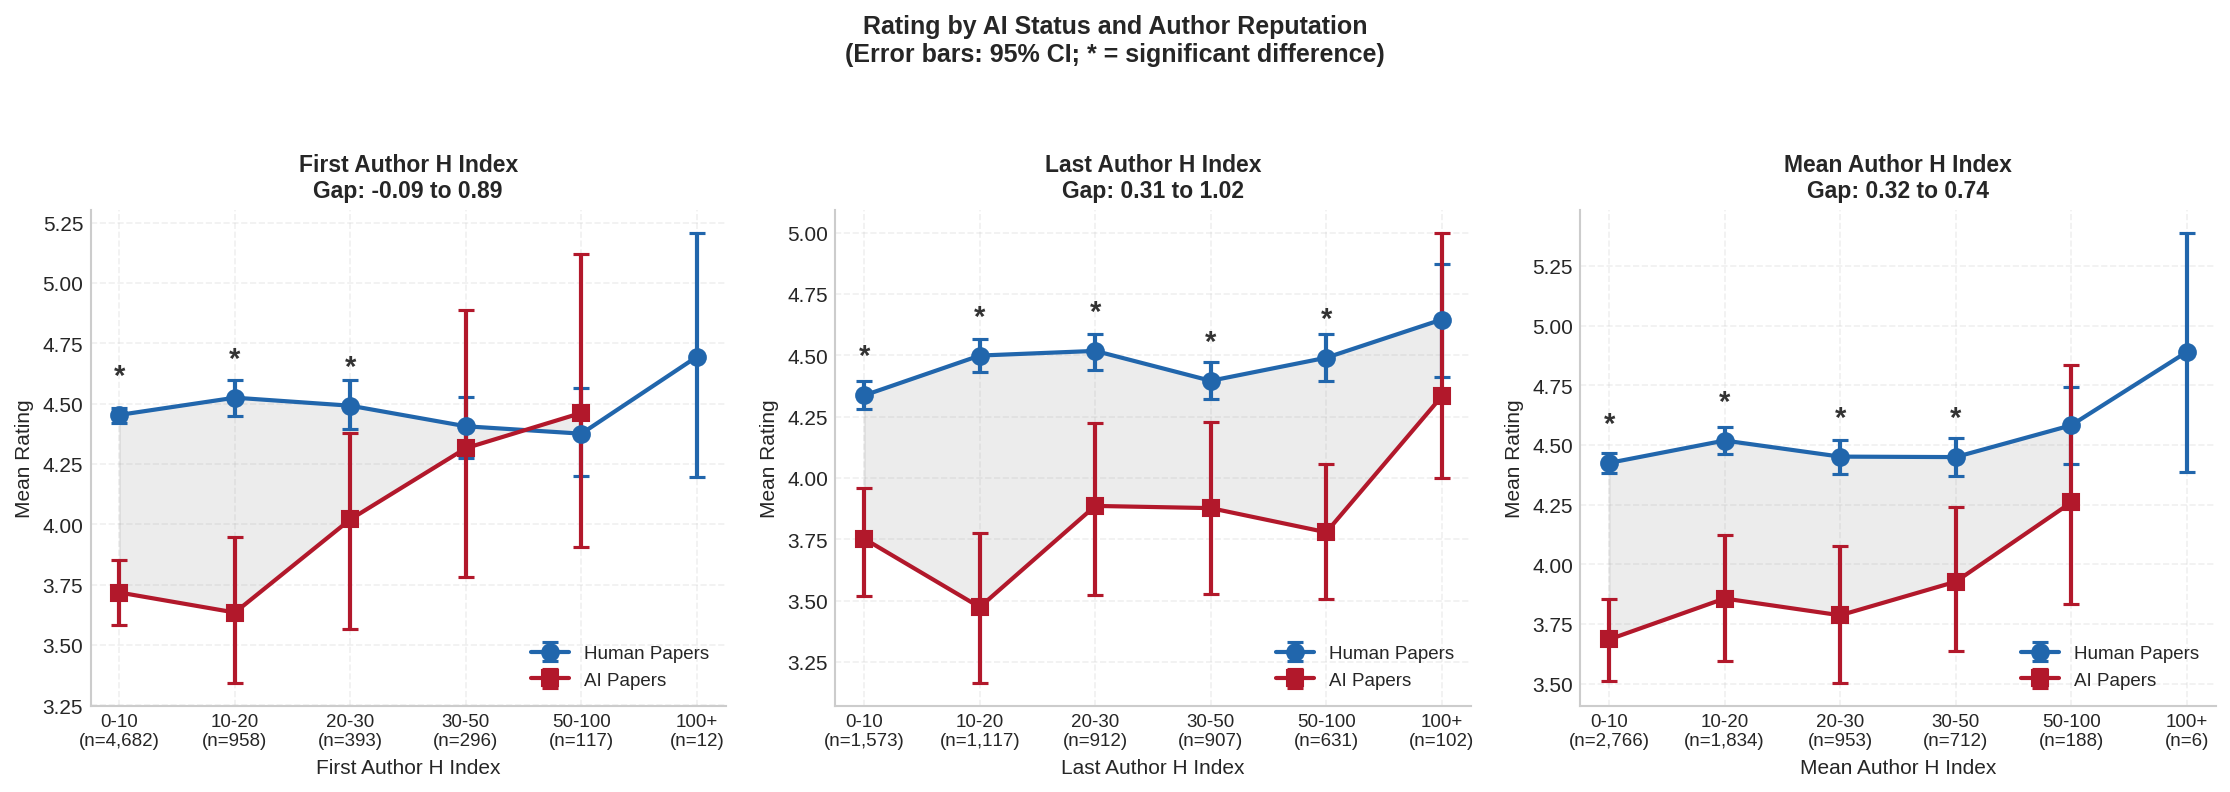

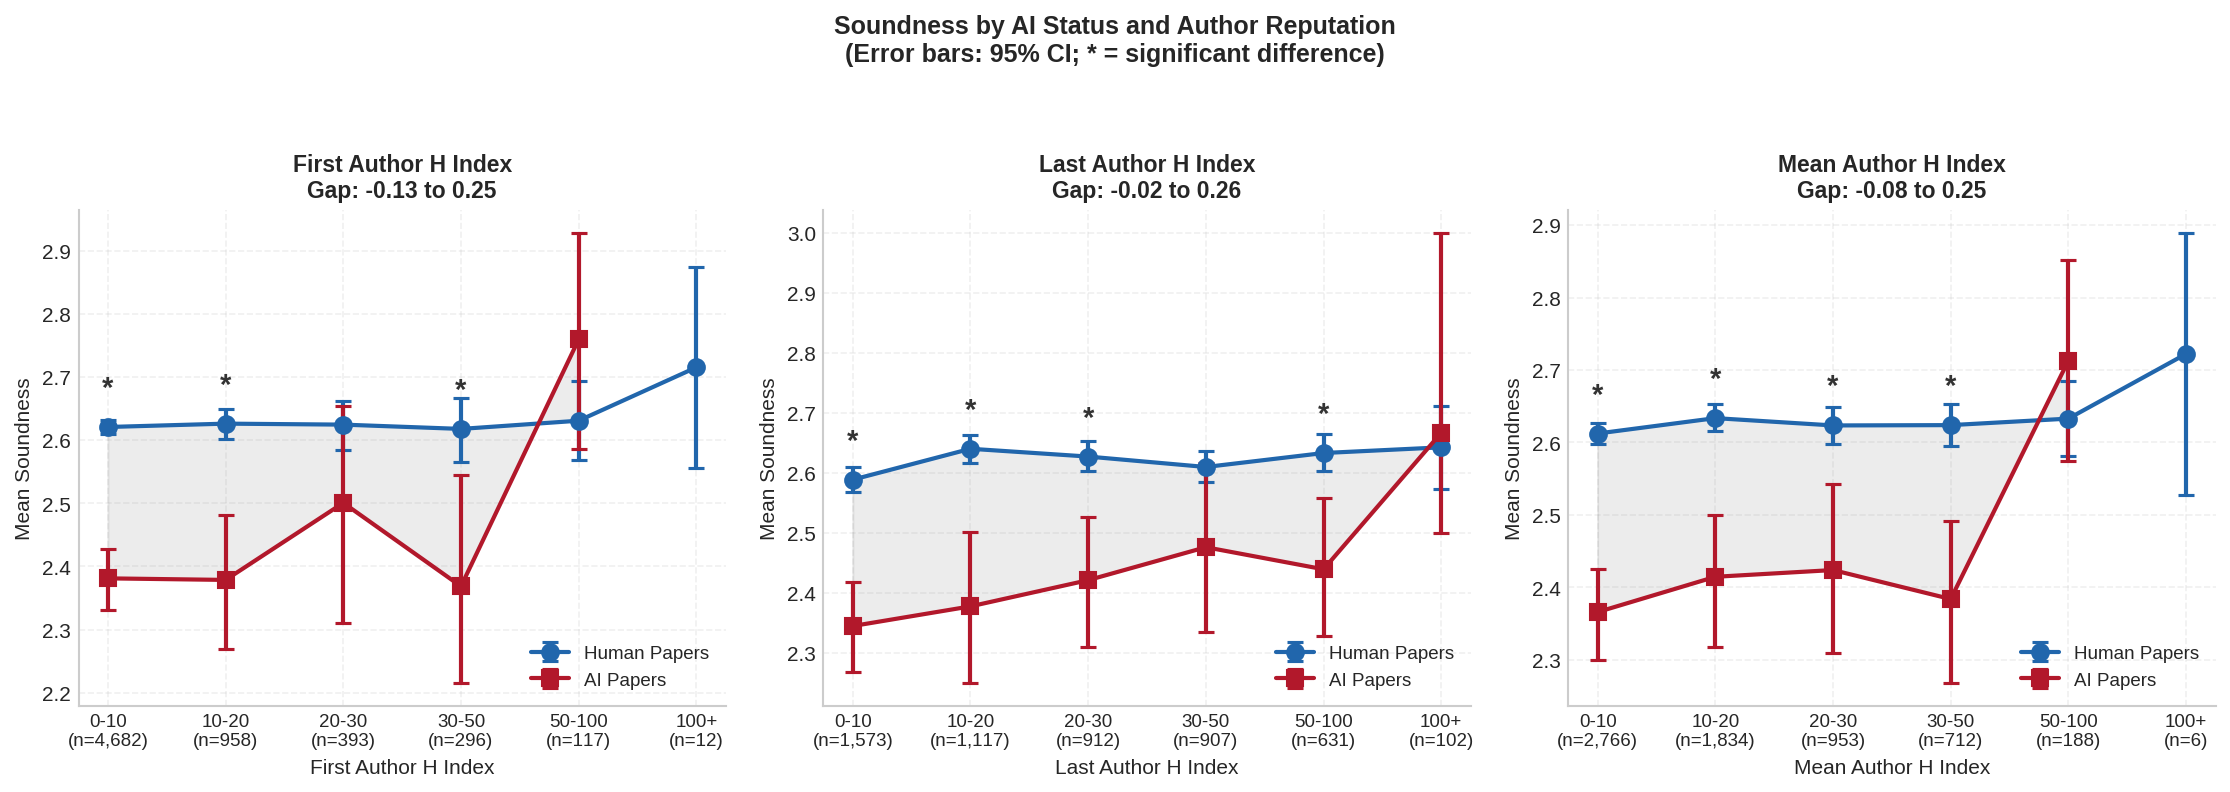

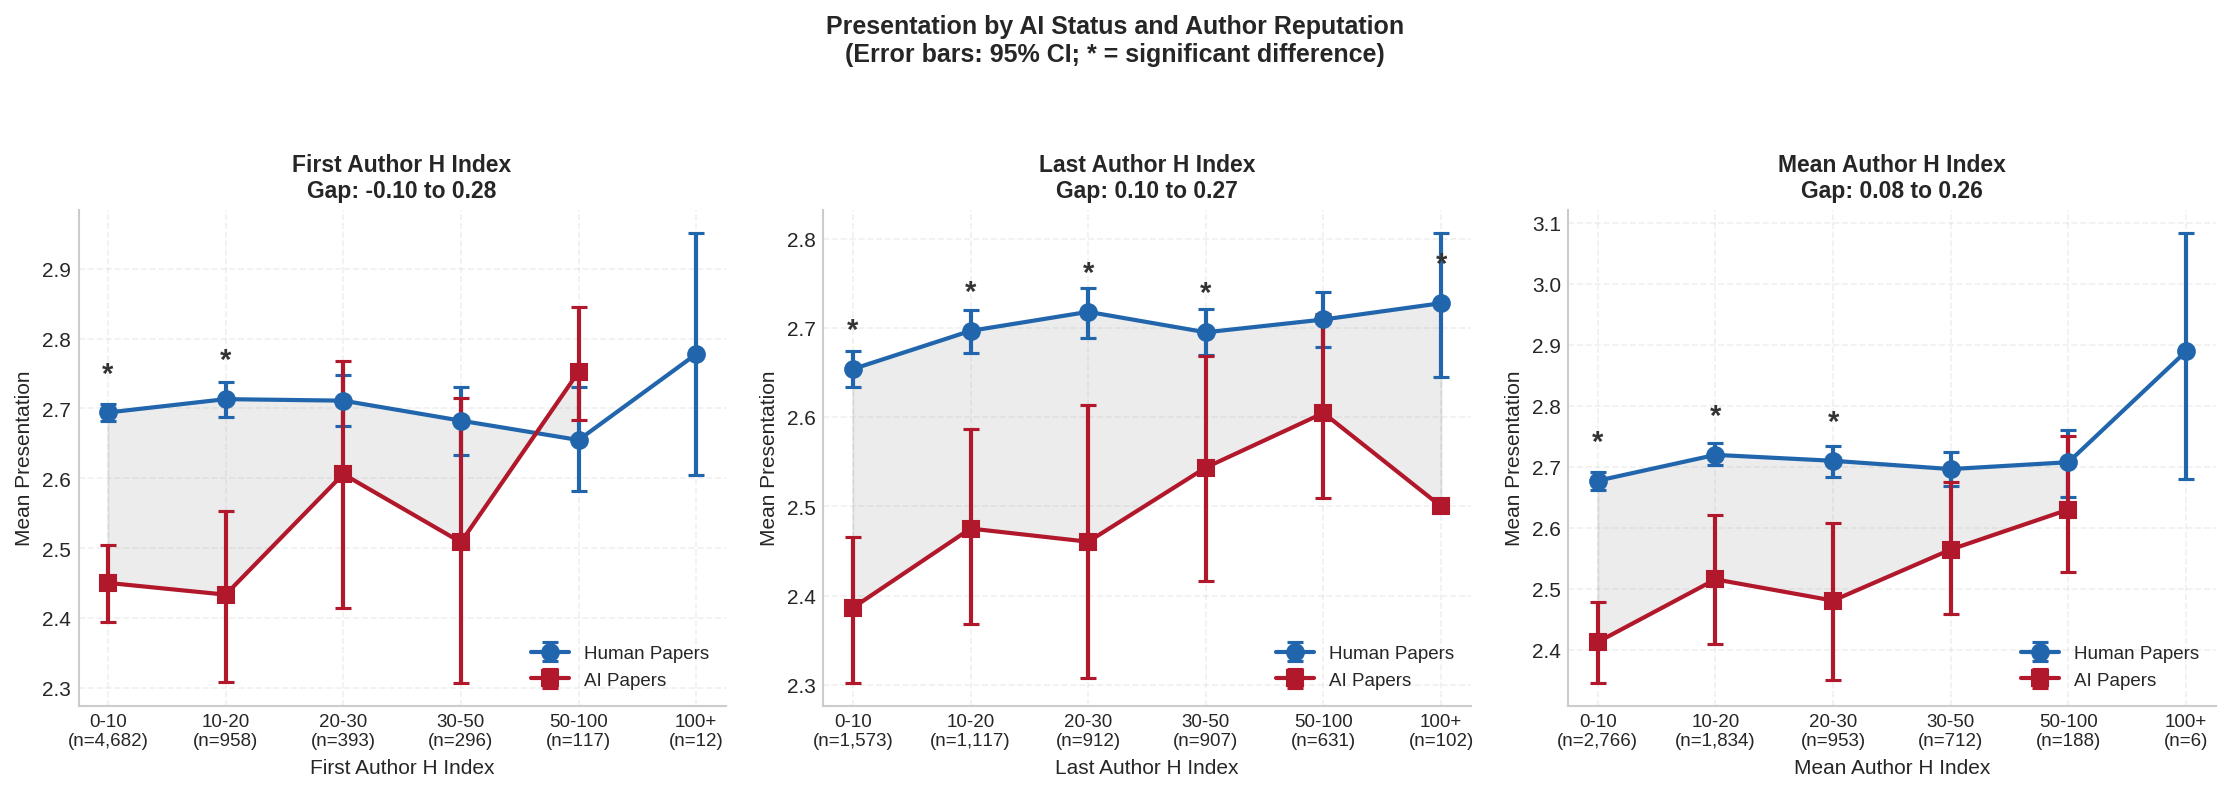

In [27]:
# Run extended interaction analysis across components and h-index measures
from arxiv_integration.analysis.selection_robustness import (
    run_full_interaction_analysis,
    run_component_interaction_analysis,
    create_interaction_plots
)

# Run comprehensive analysis
interaction_results = run_full_interaction_analysis(
    reviews_df=reviews_df,
    submissions_df=submissions_df,
    enriched_df=enriched_df,
    components=['rating', 'soundness', 'presentation', 'contribution'],
    h_index_cols=['first_author_h_index', 'last_author_h_index', 'mean_author_h_index'],
    output_dir=OUTPUT_DIR,
    verbose=True,
    save_plots=True
)

# Display the summary table
if interaction_results.get('component_interactions') and interaction_results['component_interactions'].get('summary_table') is not None:
    print("\n" + "=" * 70)
    print("COMPONENT × H-INDEX INTERACTION SUMMARY")
    print("=" * 70)
    display(interaction_results['component_interactions']['summary_table'])

INTERACTION PLOTS: Rating by AI Status and Author Experience

Showing how the AI penalty varies across h-index measures:
  - First Author: Often junior researcher who did the work
  - Last Author: Senior researcher providing supervision
  - Mean Author: Average team expertise

──────────────────────────────────────────────────────────────────────
RATING
──────────────────────────────────────────────────────────────────────


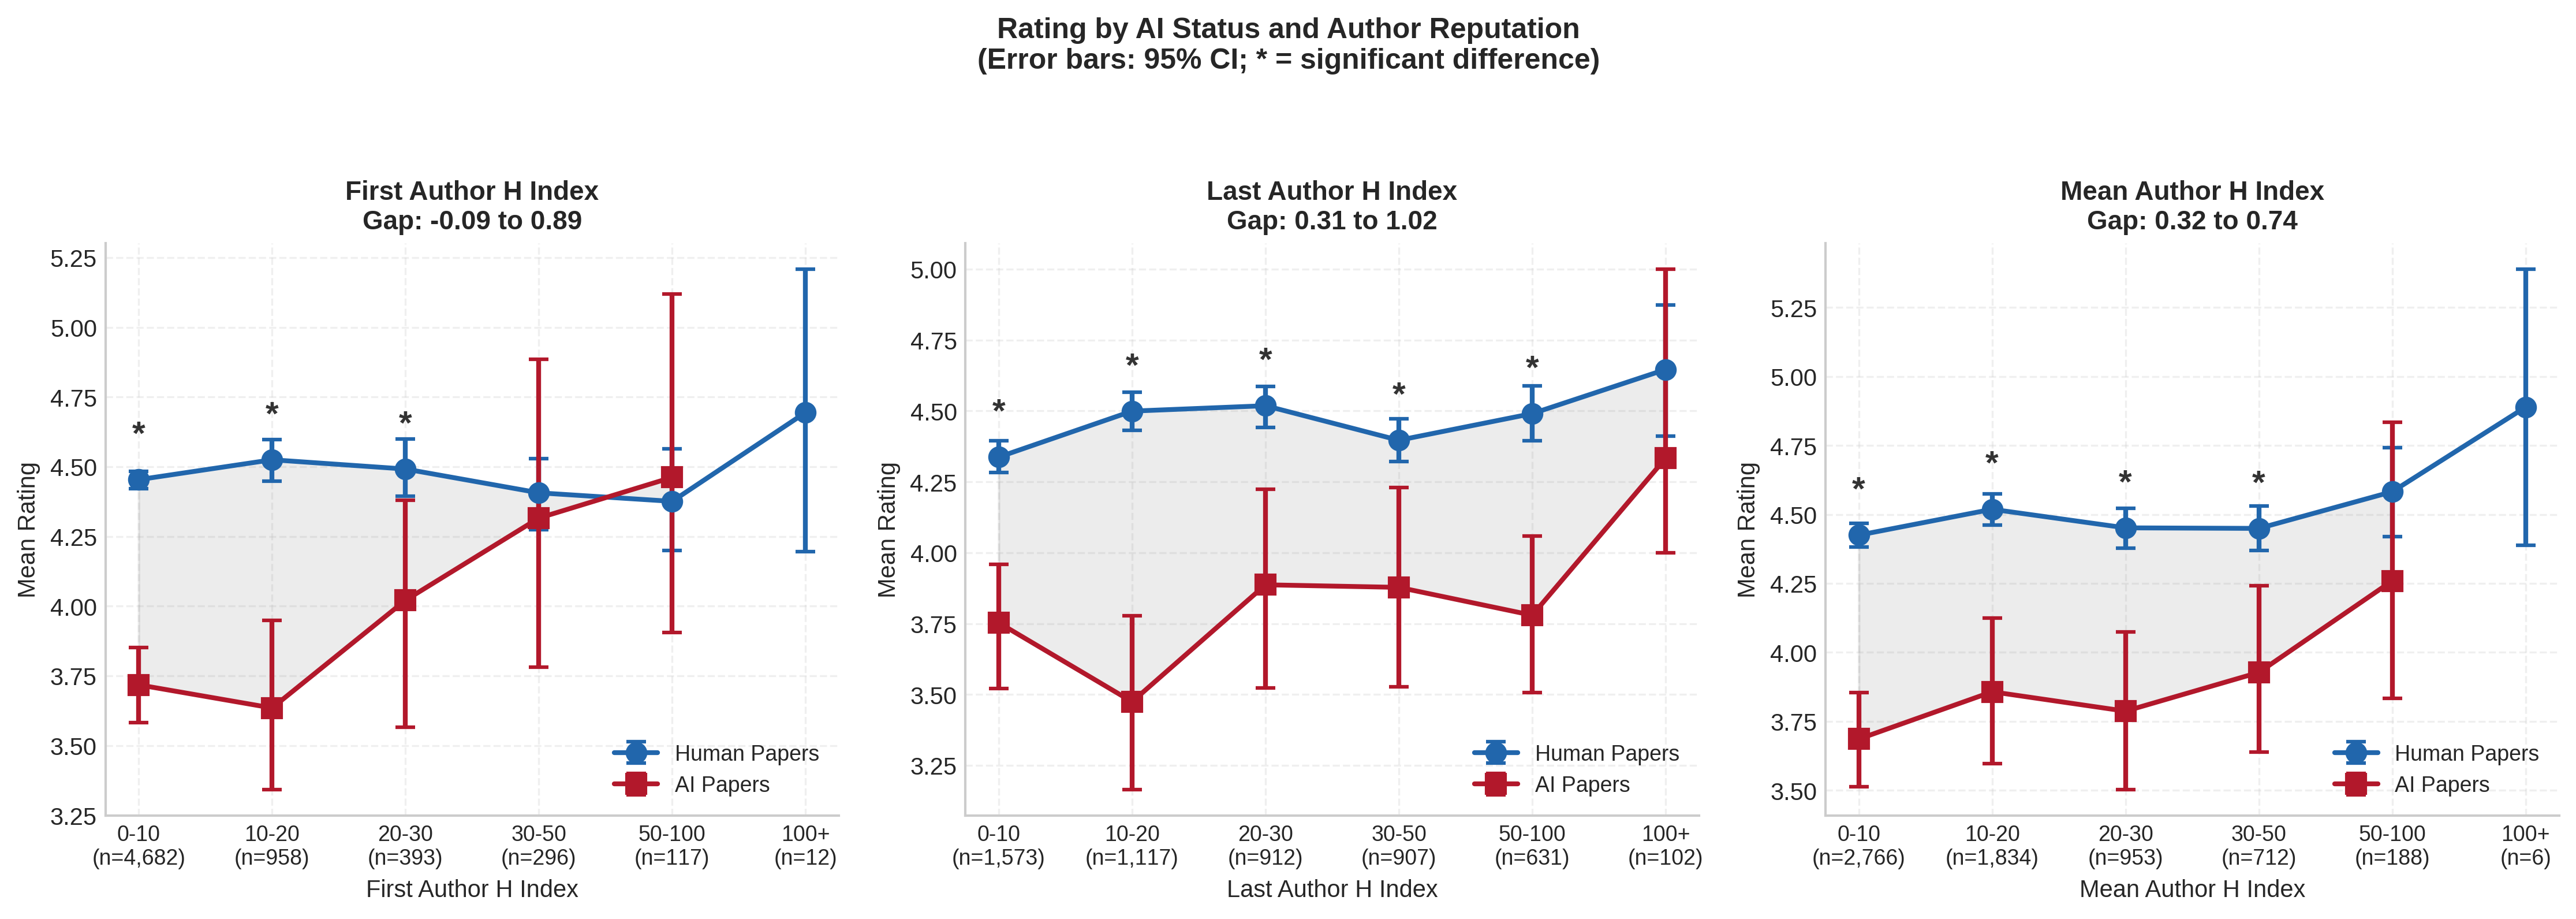


──────────────────────────────────────────────────────────────────────
SOUNDNESS
──────────────────────────────────────────────────────────────────────


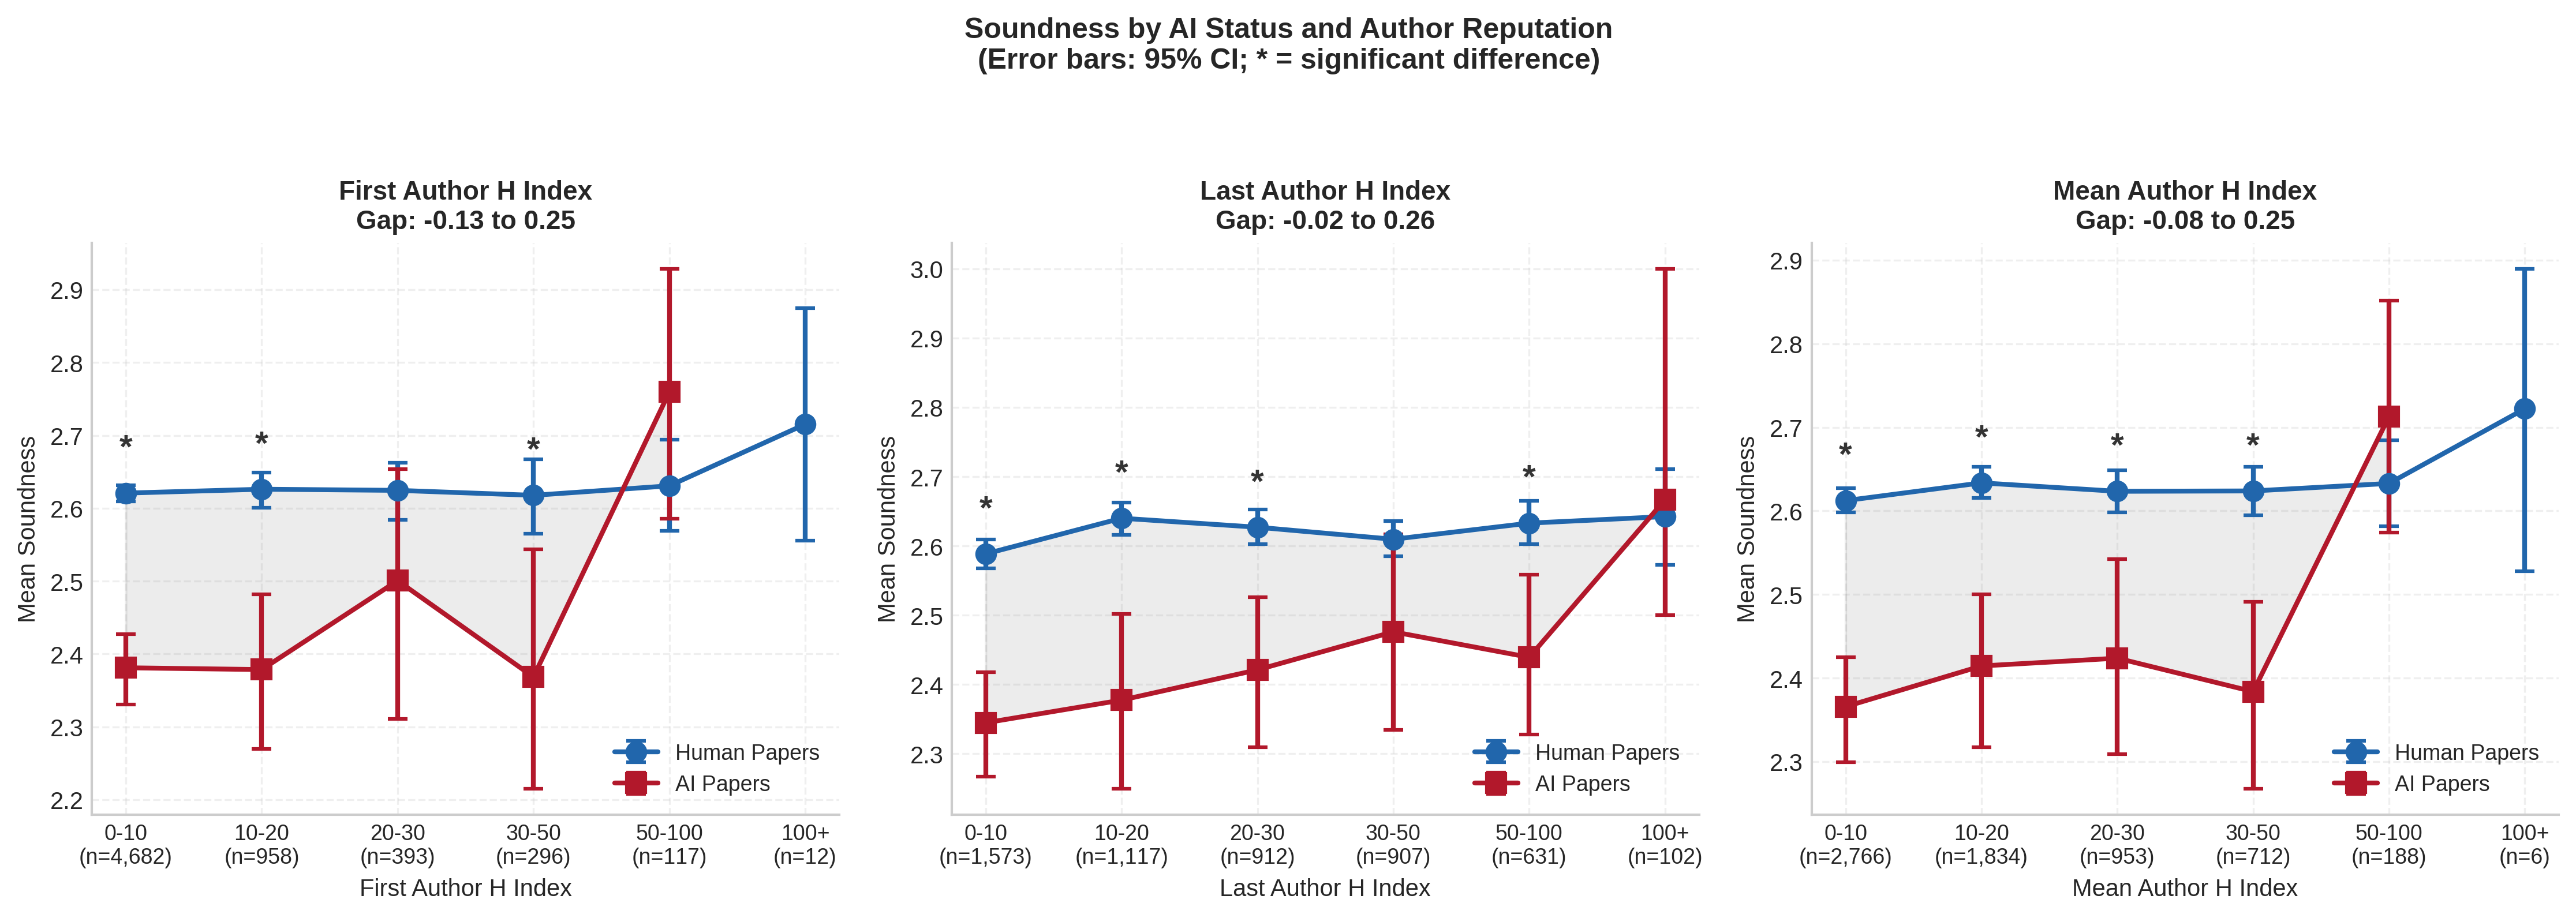


──────────────────────────────────────────────────────────────────────
PRESENTATION
──────────────────────────────────────────────────────────────────────


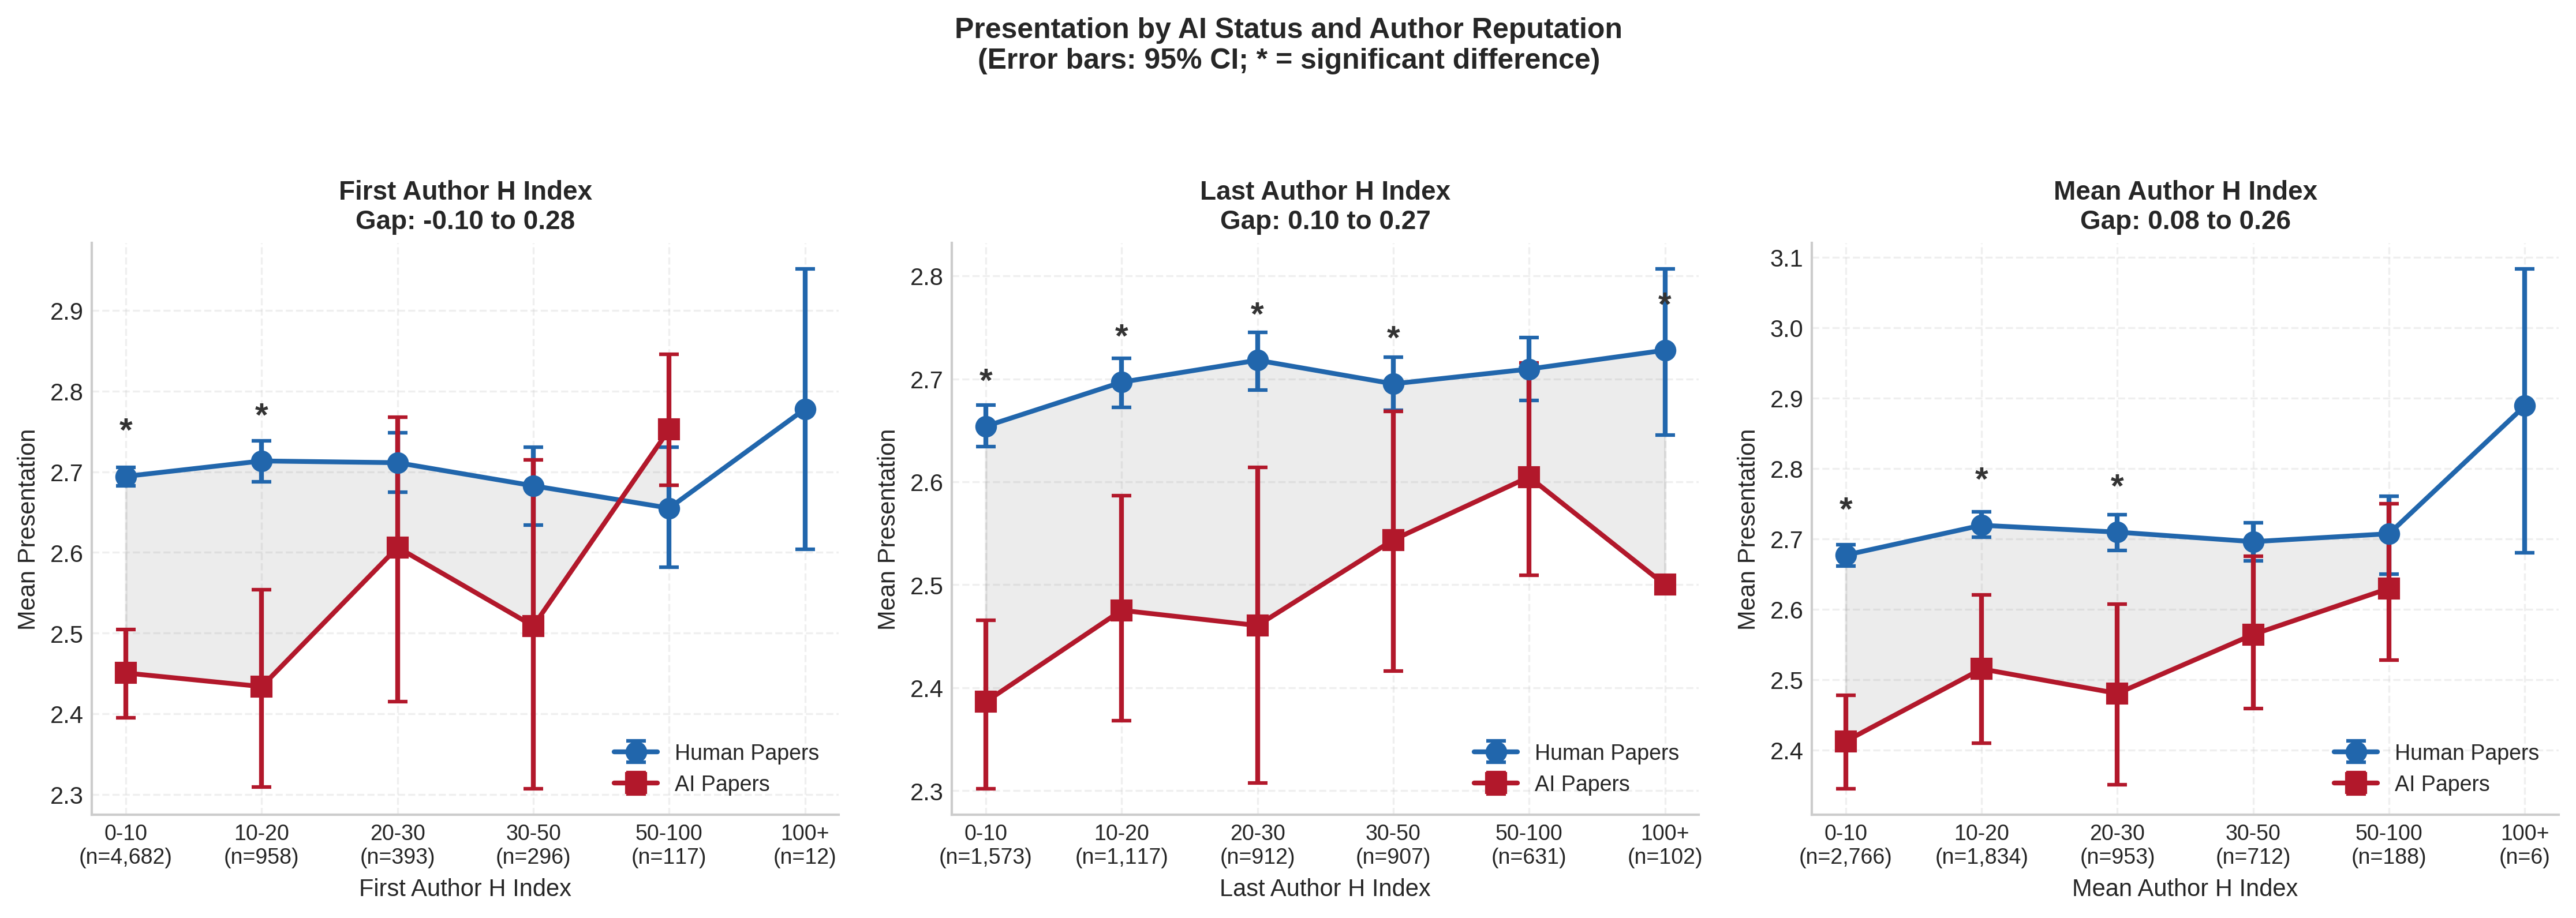

In [28]:
# Display interaction plots for different outcomes
from IPython.display import Image, display

print("=" * 70)
print("INTERACTION PLOTS: Rating by AI Status and Author Experience")
print("=" * 70)
print("\nShowing how the AI penalty varies across h-index measures:")
print("  - First Author: Often junior researcher who did the work")
print("  - Last Author: Senior researcher providing supervision")
print("  - Mean Author: Average team expertise")

# Display saved plots
for outcome in ['rating', 'soundness', 'presentation']:
    plot_path = f'{OUTPUT_DIR}/interaction_plot_{outcome}.png'
    if os.path.exists(plot_path):
        print(f"\n{'─' * 70}")
        print(f"{outcome.upper()}")
        print(f"{'─' * 70}")
        display(Image(filename=plot_path))

## 6.2 Regression-Based Interaction Analysis (Paper-Level)

**IMPORTANT**: The previous plots showed review-level data (integer scores 1,2,3,4).
This section properly aggregates to paper-level first (mean rating per paper),
then fits OLS regression with interaction terms.

This provides:
- **Proper statistical inference** (no pseudo-replication from multiple reviews)
- **Formal p-values** for the interaction effect
- **Confidence bands** from the fitted model
- **Tercile analysis** as an alternative to arbitrary bins

REGRESSION-BASED INTERACTION ANALYSIS (PAPER-LEVEL)

This analysis:
  1. Aggregates to paper-level first (mean rating per paper)
  2. Fits OLS: outcome ~ AI + h_index + AI × h_index
  3. Tests whether AI effect varies with author reputation

Note: 'merged' data was prepared in cell above


OUTCOME: SOUNDNESS
Aggregated to paper level: 75,800 reviews → 19,472 papers
  Mean reviews per paper: 3.9
Saved: /content/HAI-Frontier/last_results/arxiv_author/interaction_regression_soundness.png

REGRESSION INTERACTION ANALYSIS: SOUNDNESS (Paper-Level)
Model: soundness ~ AI + h_index + AI × h_index

H-index Measure             Interaction β         SE    p-value    Sig       R²        N
----------------------------------------------------------------------------------
first_author_h_index             +0.00303    0.00167     0.0691          0.0178    6,458
last_author_h_index              +0.00142    0.00098     0.1476          0.0173    5,242
mean_author_h_index              +0.00317    0.00150  

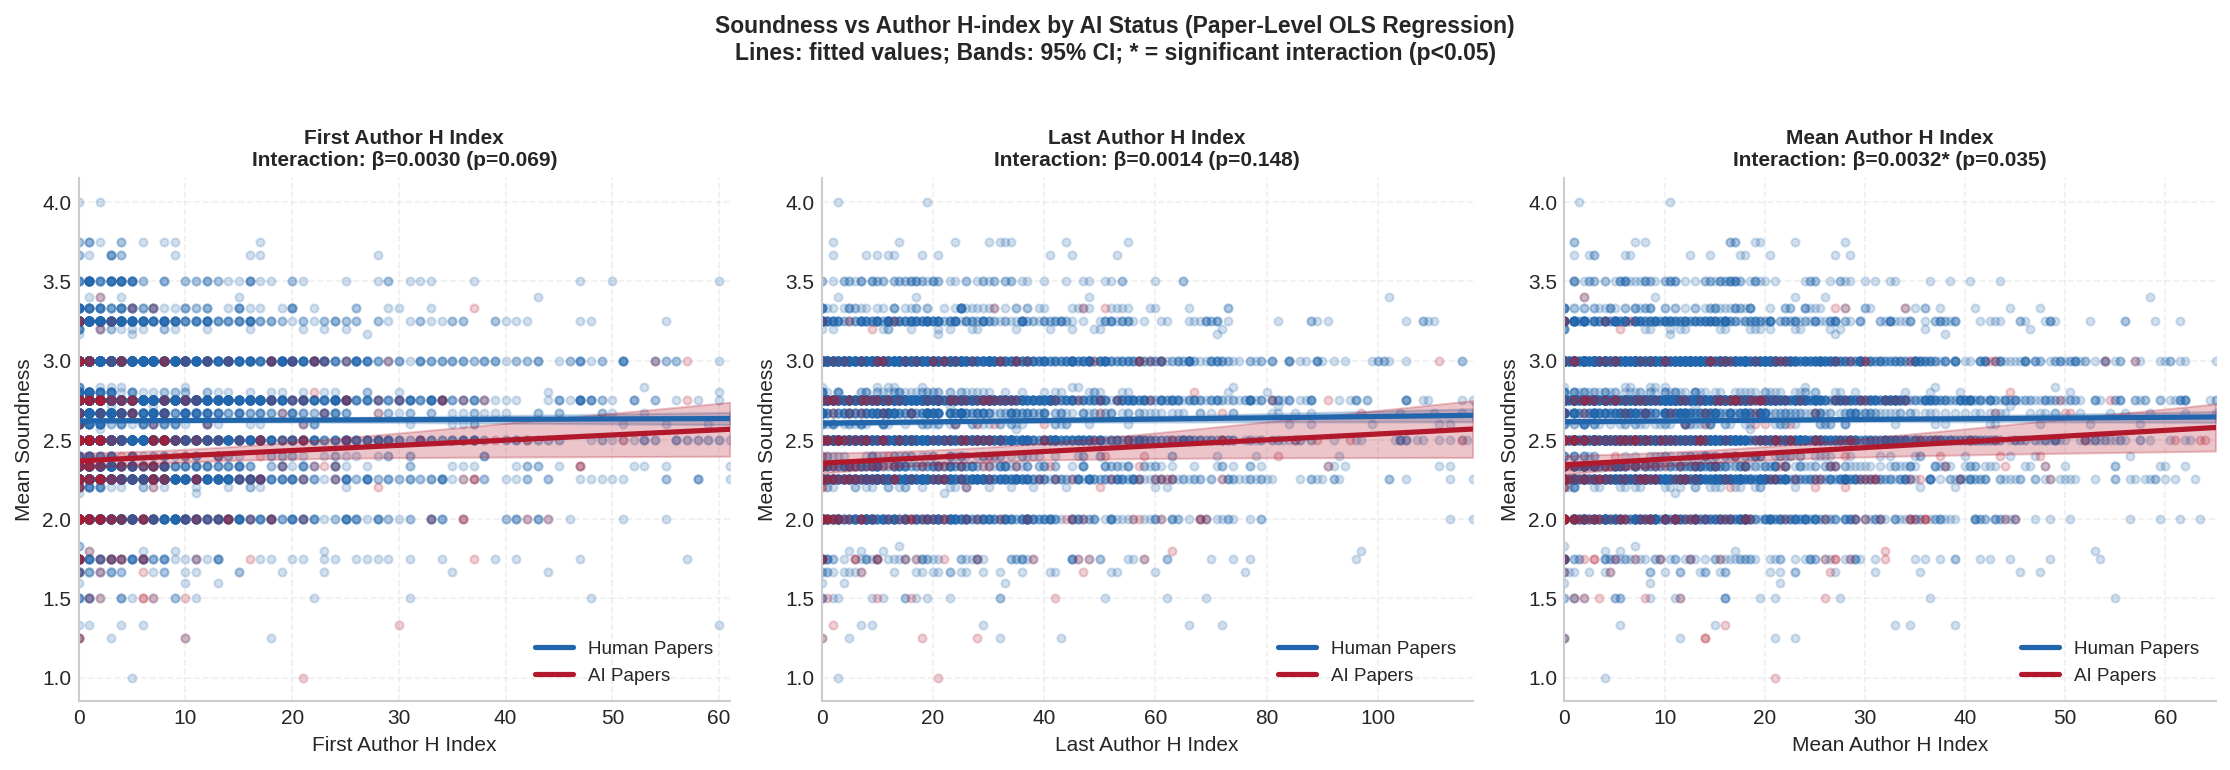



OUTCOME: PRESENTATION
Aggregated to paper level: 75,800 reviews → 19,472 papers
  Mean reviews per paper: 3.9
Saved: /content/HAI-Frontier/last_results/arxiv_author/interaction_regression_presentation.png

REGRESSION INTERACTION ANALYSIS: PRESENTATION (Paper-Level)
Model: presentation ~ AI + h_index + AI × h_index

H-index Measure             Interaction β         SE    p-value    Sig       R²        N
----------------------------------------------------------------------------------
first_author_h_index             +0.00400    0.00173     0.0206      *   0.0172    6,458
last_author_h_index              +0.00174    0.00101     0.0862          0.0182    5,242
mean_author_h_index              +0.00397    0.00155     0.0105      *   0.0185    6,459

Interpretation:
  - Interaction β > 0: AI penalty DECREASES with higher h-index
  - Interaction β < 0: AI penalty INCREASES with higher h-index
  - Interaction β ≈ 0: AI penalty is CONSTANT across h-index levels

  → Significant interactions

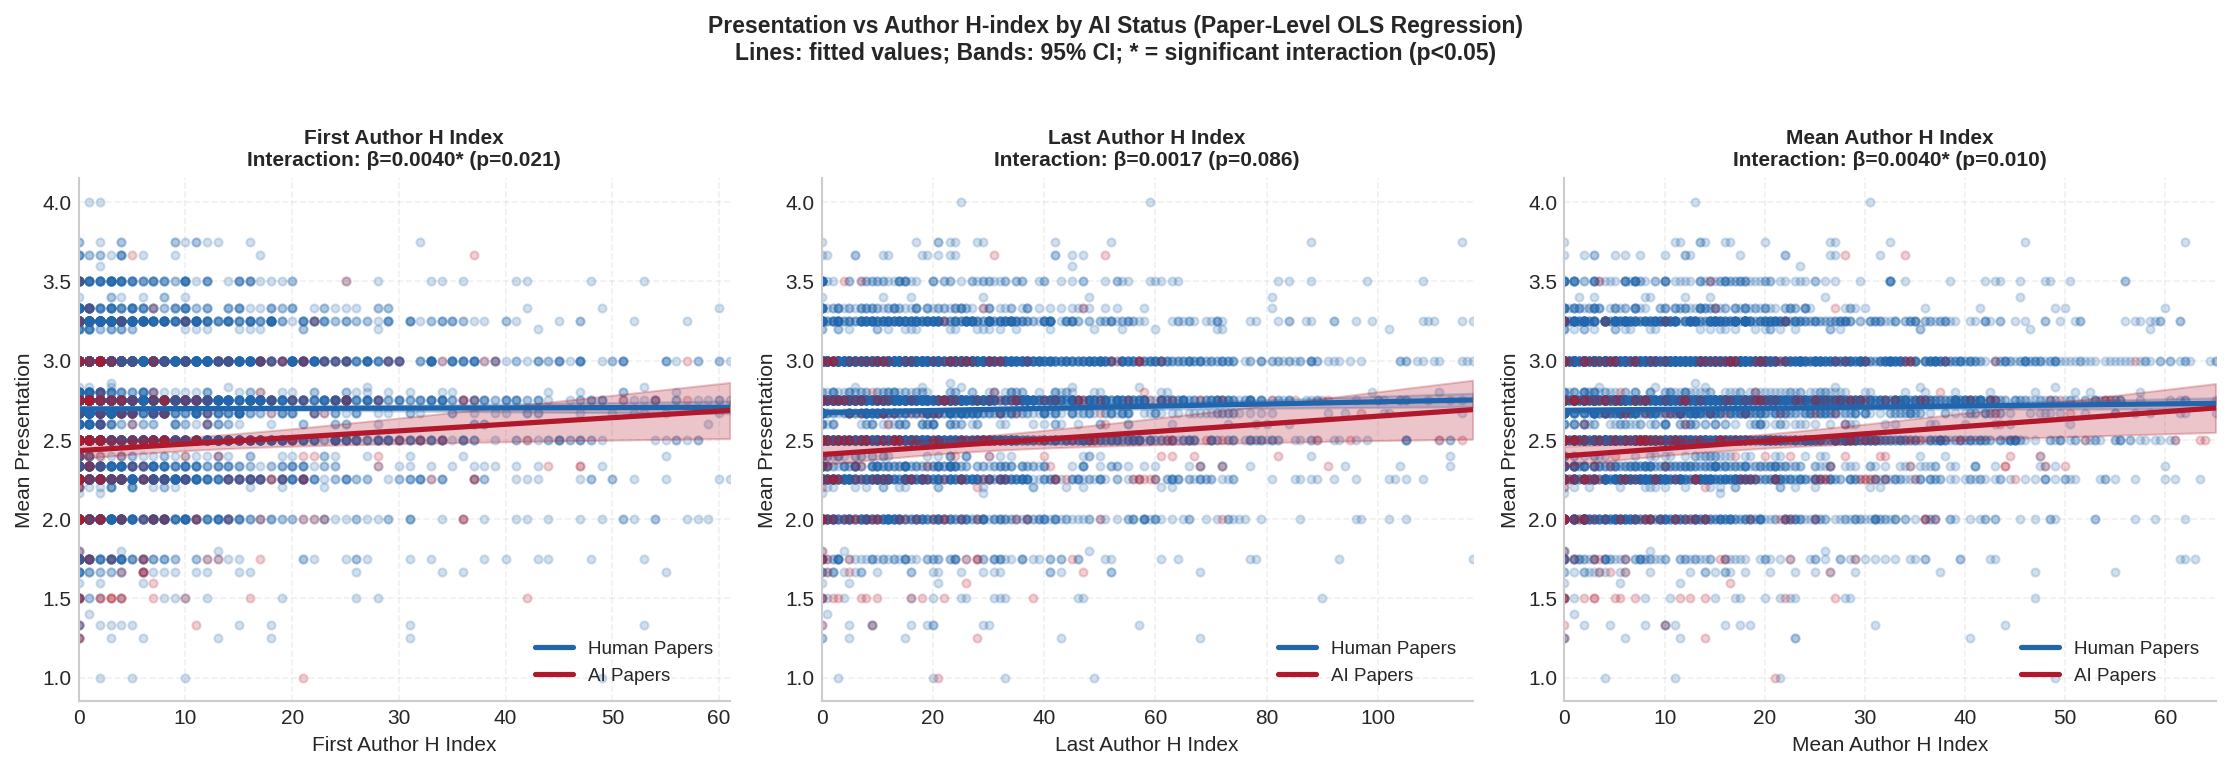



OUTCOME: RATING
Aggregated to paper level: 75,800 reviews → 19,472 papers
  Mean reviews per paper: 3.9
Saved: /content/HAI-Frontier/last_results/arxiv_author/interaction_regression_rating.png

REGRESSION INTERACTION ANALYSIS: RATING (Paper-Level)
Model: rating ~ AI + h_index + AI × h_index

H-index Measure             Interaction β         SE    p-value    Sig       R²        N
----------------------------------------------------------------------------------
first_author_h_index             +0.01306    0.00491     0.0078      *   0.0194    6,458
last_author_h_index              +0.00023    0.00286     0.9372          0.0195    5,242
mean_author_h_index              +0.00732    0.00442     0.0974          0.0193    6,459

Interpretation:
  - Interaction β > 0: AI penalty DECREASES with higher h-index
  - Interaction β < 0: AI penalty INCREASES with higher h-index
  - Interaction β ≈ 0: AI penalty is CONSTANT across h-index levels

  → Significant interactions found for: first_author

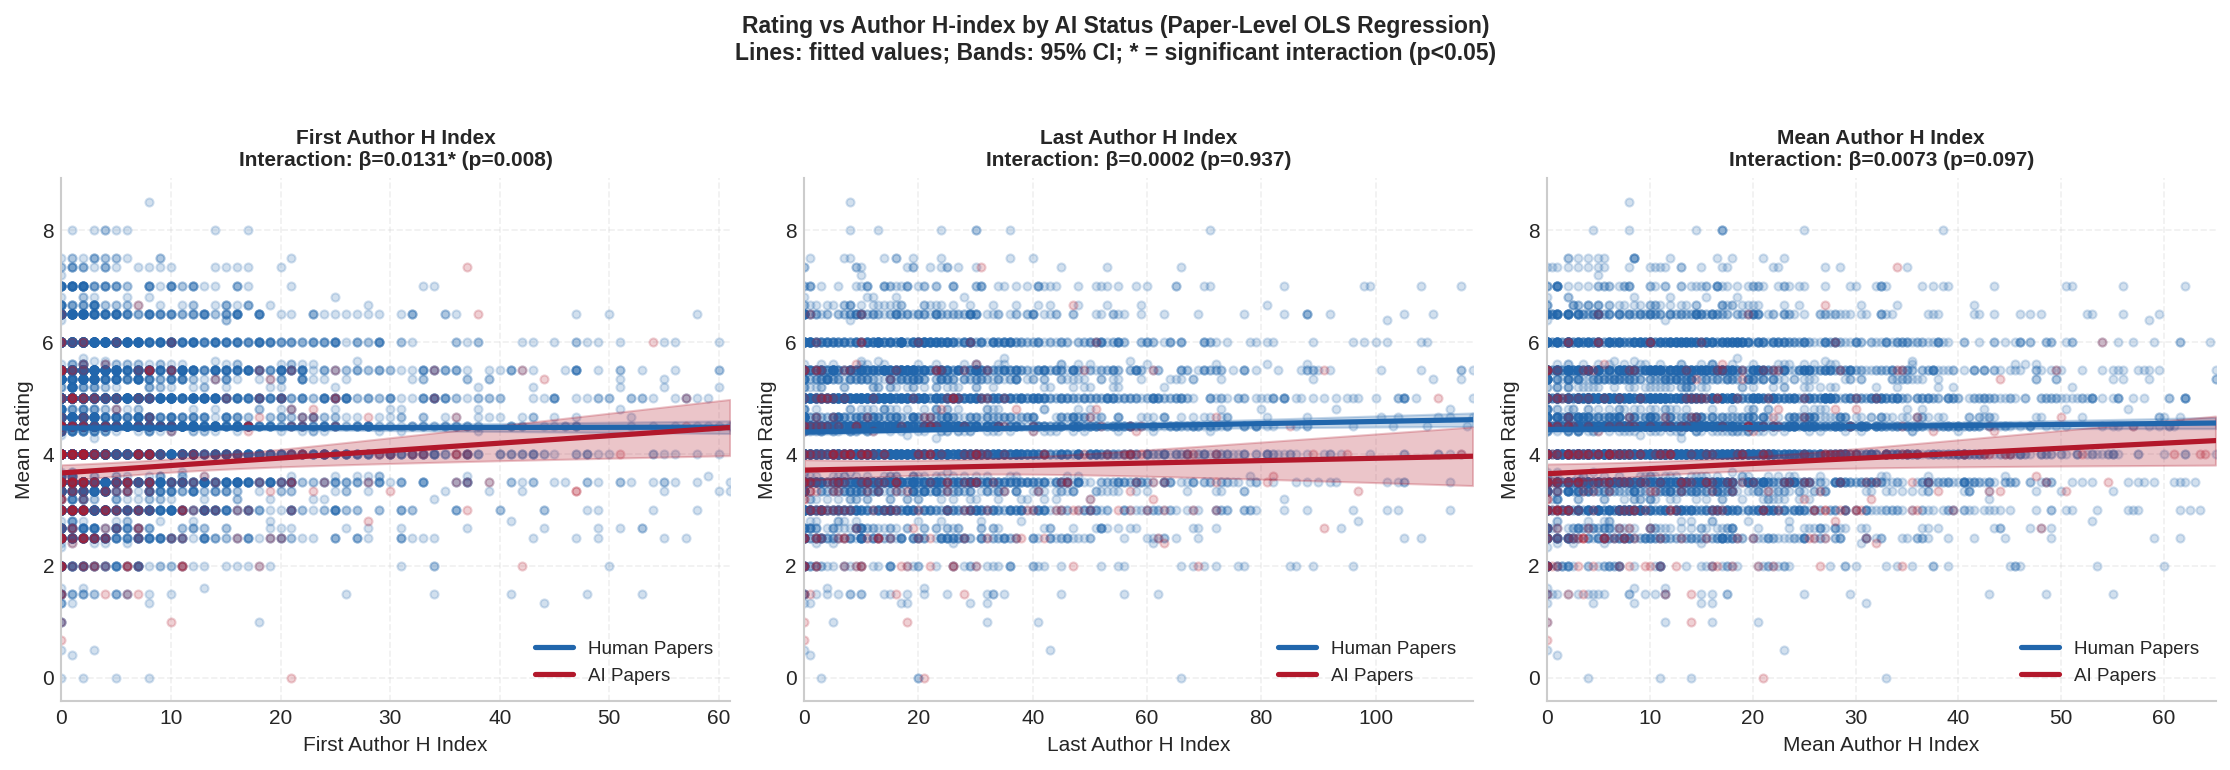

In [29]:
# Regression-based interaction plots (paper-level)
from arxiv_integration.analysis.selection_robustness import (
    create_interaction_plots_regression,
    create_interaction_plots_terciles
)

print("=" * 70)
print("REGRESSION-BASED INTERACTION ANALYSIS (PAPER-LEVEL)")
print("=" * 70)
print("\nThis analysis:")
print("  1. Aggregates to paper-level first (mean rating per paper)")
print("  2. Fits OLS: outcome ~ AI + h_index + AI × h_index")
print("  3. Tests whether AI effect varies with author reputation")
print("\nNote: 'merged' data was prepared in cell above")

# Run for each outcome
for outcome in ['soundness', 'presentation', 'rating']:
    print(f"\n\n{'='*70}")
    print(f"OUTCOME: {outcome.upper()}")
    print(f"{'='*70}")

    reg_results = create_interaction_plots_regression(
        df=merged,
        outcome=outcome,
        h_index_cols=['first_author_h_index', 'last_author_h_index', 'mean_author_h_index'],
        output_dir=OUTPUT_DIR,
        verbose=True,
        show_scatter=True,
        scatter_alpha=0.2,
        aggregate_to_paper=True
    )

    plt.show()

### Tercile Analysis (Data-Driven Bins)

Instead of arbitrary h-index bins (0-10, 10-20, etc.), terciles use data-driven cutoffs
based on the actual h-index distribution. This ensures:
- **Balanced groups** (roughly equal sample sizes)
- **No arbitrary cutoff choices**
- **Better power** (avoids sparse bins)

TERCILE ANALYSIS (DATA-DRIVEN BINS, PAPER-LEVEL)


OUTCOME: SOUNDNESS
Aggregated to paper level: 75,800 reviews → 19,472 papers
Saved: /content/HAI-Frontier/last_results/arxiv_author/interaction_terciles_soundness.png

QUANTILE-BASED INTERACTION ANALYSIS: SOUNDNESS (Paper-Level)
Using Terciles (data-driven bins)

first_author_h_index:
  Quantile     H-index           Human         AI        Gap        N
  ------------ ------------ ---------- ---------- ---------- --------
  Low          0-2               2.614      2.384     +0.230    2,489
  Medium       3-8               2.633      2.383     +0.250    1,865
  High         9-206             2.622      2.427     +0.195    2,104

last_author_h_index:
  Quantile     H-index           Human         AI        Gap        N
  ------------ ------------ ---------- ---------- ---------- --------
  Low          0-12              2.594      2.366     +0.228    1,809
  Medium       13-29             2.632      2.366     +0.267    1,699
  High     

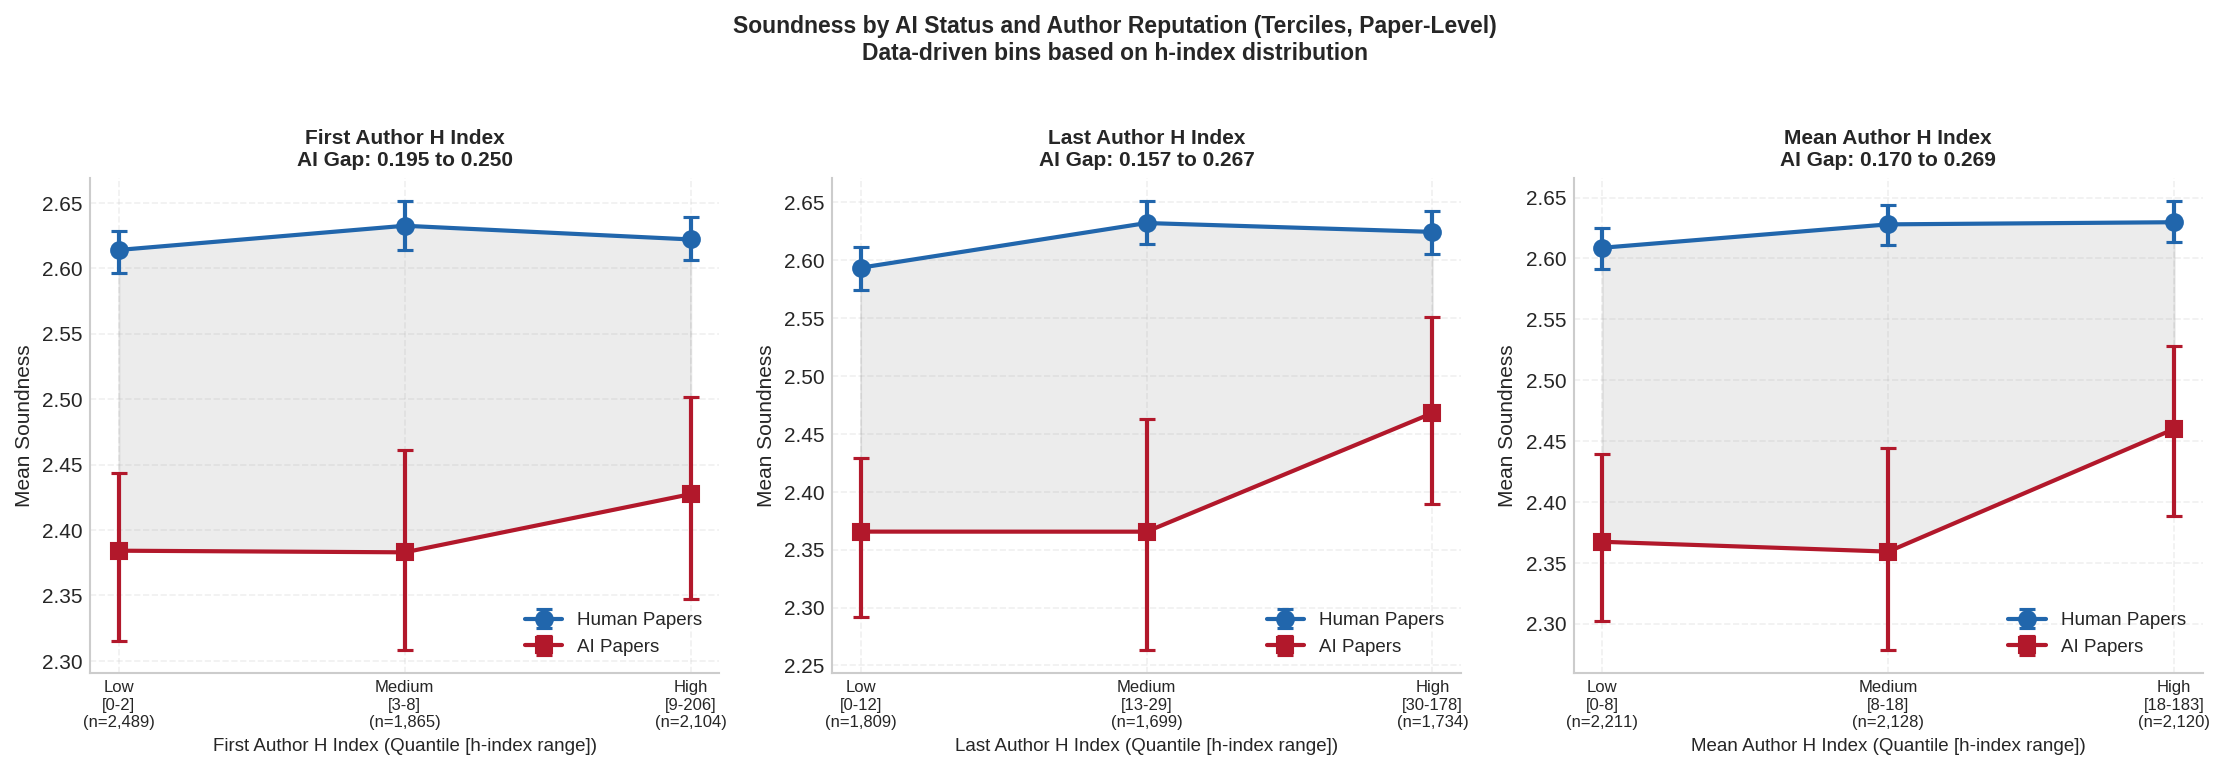



OUTCOME: PRESENTATION
Aggregated to paper level: 75,800 reviews → 19,472 papers
Saved: /content/HAI-Frontier/last_results/arxiv_author/interaction_terciles_presentation.png

QUANTILE-BASED INTERACTION ANALYSIS: PRESENTATION (Paper-Level)
Using Terciles (data-driven bins)

first_author_h_index:
  Quantile     H-index           Human         AI        Gap        N
  ------------ ------------ ---------- ---------- ---------- --------
  Low          0-2               2.679      2.449     +0.231    2,489
  Medium       3-8               2.710      2.441     +0.268    1,865
  High         9-206             2.707      2.525     +0.181    2,104

last_author_h_index:
  Quantile     H-index           Human         AI        Gap        N
  ------------ ------------ ---------- ---------- ---------- --------
  Low          0-12              2.656      2.414     +0.242    1,809
  Medium       13-29             2.707      2.419     +0.287    1,699
  High         30-178            2.707      2.576  

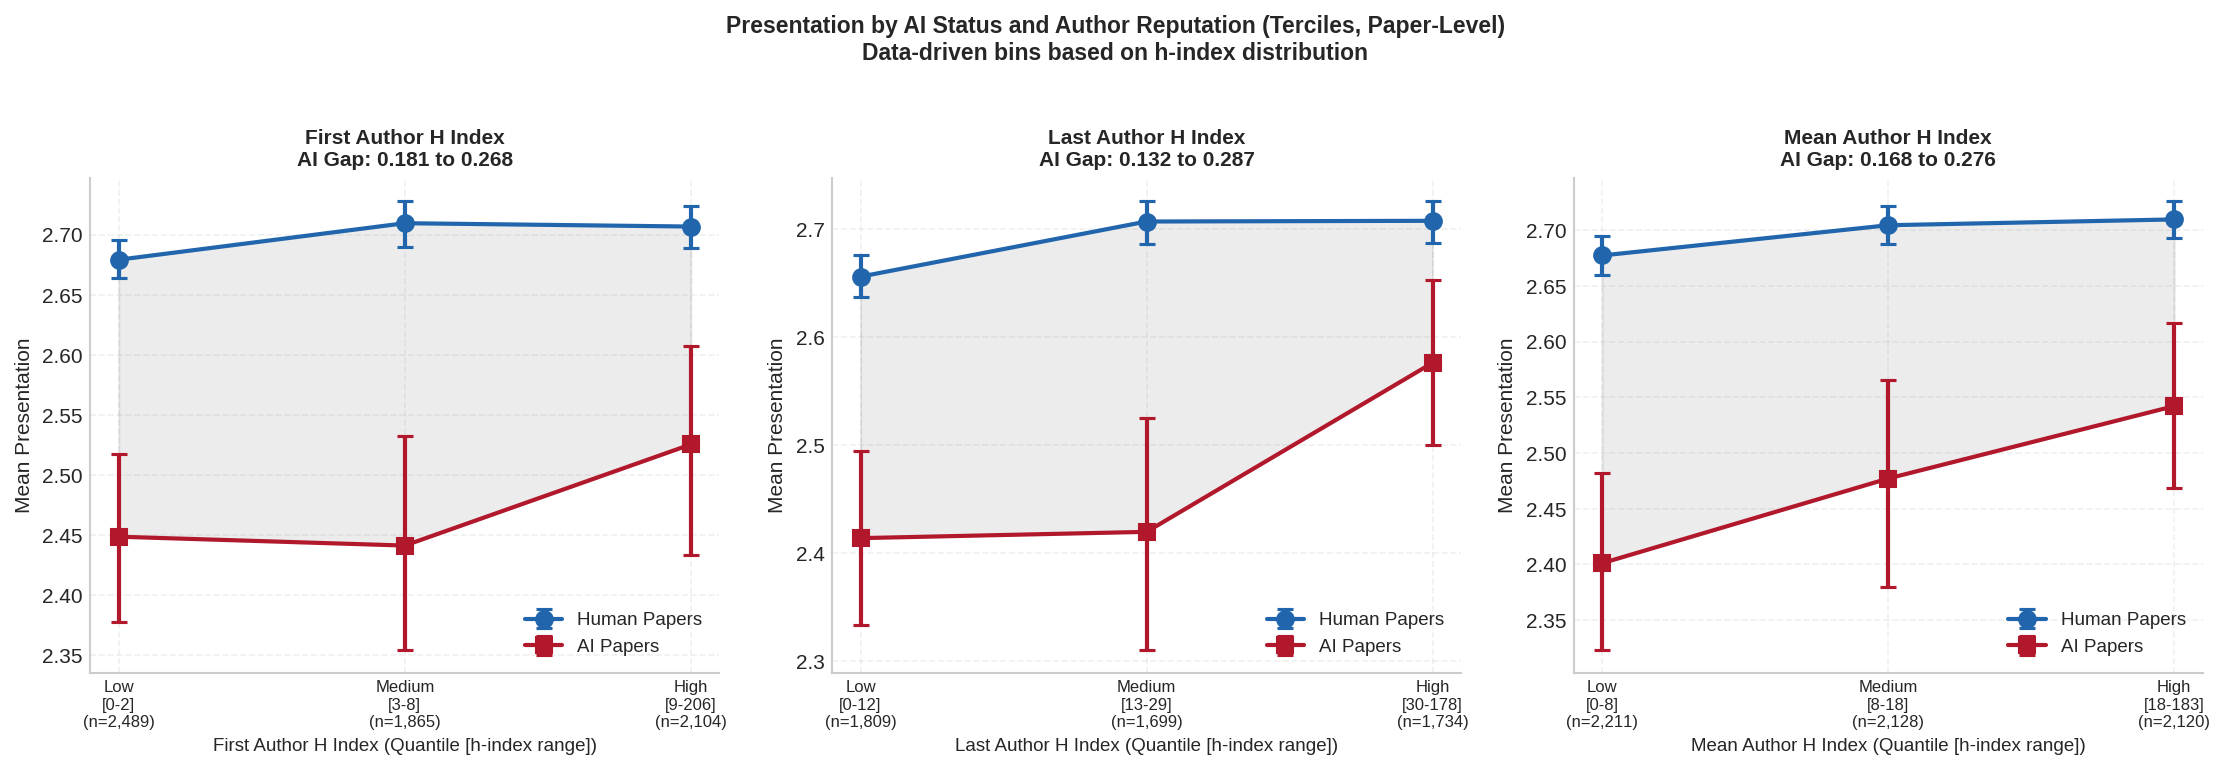



OUTCOME: RATING
Aggregated to paper level: 75,800 reviews → 19,472 papers
Saved: /content/HAI-Frontier/last_results/arxiv_author/interaction_terciles_rating.png

QUANTILE-BASED INTERACTION ANALYSIS: RATING (Paper-Level)
Using Terciles (data-driven bins)

first_author_h_index:
  Quantile     H-index           Human         AI        Gap        N
  ------------ ------------ ---------- ---------- ---------- --------
  Low          0-2               4.440      3.739     +0.701    2,489
  Medium       3-8               4.468      3.636     +0.831    1,865
  High         9-206             4.487      3.961     +0.526    2,104

last_author_h_index:
  Quantile     H-index           Human         AI        Gap        N
  ------------ ------------ ---------- ---------- ---------- --------
  Low          0-12              4.359      3.760     +0.598    1,809
  Medium       13-29             4.497      3.659     +0.838    1,699
  High         30-178            4.463      3.844     +0.620    1,734

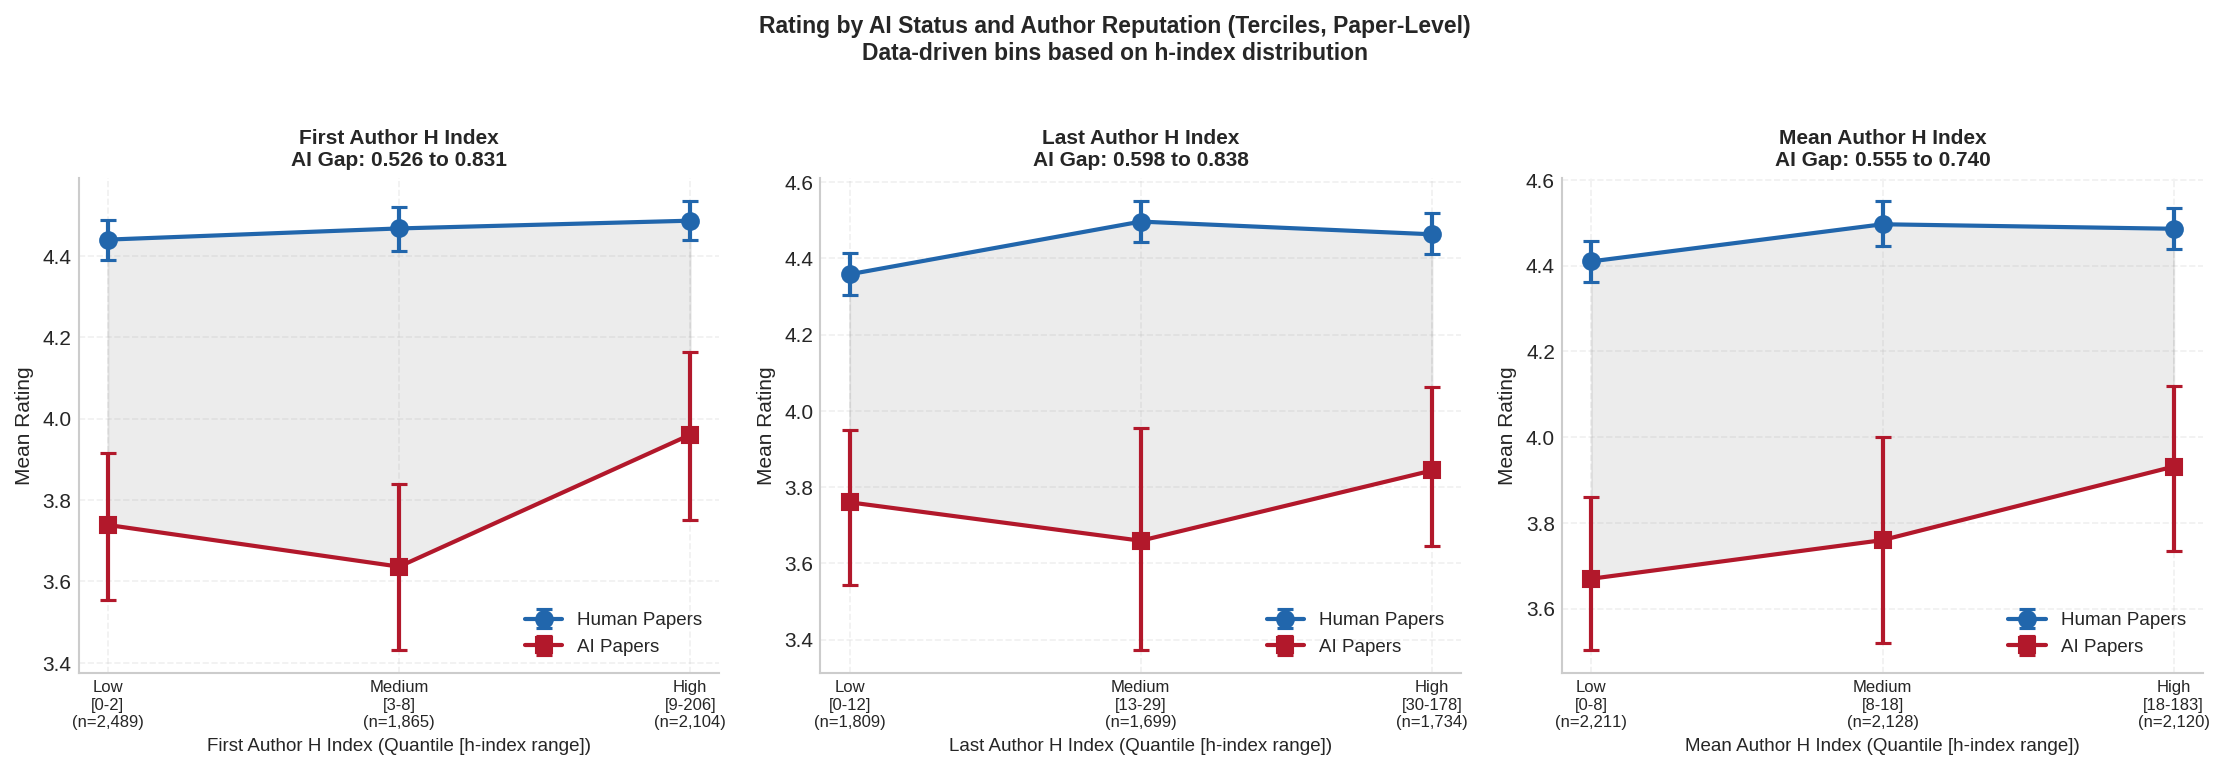

In [30]:
# Tercile-based interaction analysis (paper-level)
print("=" * 70)
print("TERCILE ANALYSIS (DATA-DRIVEN BINS, PAPER-LEVEL)")
print("=" * 70)

for outcome in ['soundness', 'presentation', 'rating']:
    print(f"\n\n{'='*70}")
    print(f"OUTCOME: {outcome.upper()}")
    print(f"{'='*70}")

    tercile_results = create_interaction_plots_terciles(
        df=merged,
        outcome=outcome,
        h_index_cols=['first_author_h_index', 'last_author_h_index', 'mean_author_h_index'],
        output_dir=OUTPUT_DIR,
        verbose=True,
        aggregate_to_paper=True
    )

    plt.show()

## 6.3 Stacked Regression Test: Substitution Signature (QJE/REStud-Ready)

**This is the PREFERRED test for top journals.**

Instead of looking at whether the Presentation-Soundness *gap increases* with AI content,
we directly test whether AI affects Soundness MORE NEGATIVELY than Presentation.

**Model:**
```
Score ~ AI% + is_soundness + AI% × is_soundness
```

**Interpretation:**
- The interaction term (AI% × is_soundness) tests differential effect
- If negative & significant: AI hurts Soundness MORE than Presentation
- This is the "substitution signature" - AI helps style, not substance

**Why this is better:**
1. No arbitrary bins - uses continuous AI%
2. Single, pre-specifiable hypothesis test
3. Formal coefficient comparison with proper inference

In [31]:
# Stacked Regression Test for Substitution Signature
from iclr_analysis.analysis.effort_proxies import test_substitution_stacked_regression

print("=" * 70)
print("STACKED REGRESSION TEST: Soundness vs Presentation")
print("=" * 70)
print("\nThis is the QJE/REStud-ready formal test for substitution signature.")
print("We test: Does AI affect Soundness MORE NEGATIVELY than Presentation?")

# Run the stacked regression test
stacked_results = test_substitution_stacked_regression(
    reviews_df=reviews_df,
    submissions_df=submissions_df,
    verbose=True,
    create_figure=True,
    save_path=f'{OUTPUT_DIR}/fig_substitution_stacked_regression.png'
)

plt.show()

# Display key result
print("\n" + "=" * 70)
print("KEY RESULT FOR PAPER")
print("=" * 70)
diff = stacked_results['effects']['difference']
print(f"\nInteraction (AI% × is_soundness): {diff['coef']:.6f}")
print(f"p-value: {diff['p_value']:.4e}")
print(f"\nEffect per 100% AI content:")
print(f"  Presentation: {stacked_results['effects']['presentation']['per_100pct']:+.4f} points")
print(f"  Soundness:    {stacked_results['effects']['soundness']['per_100pct']:+.4f} points")
print(f"  Difference:   {diff['per_100pct']:+.4f} points")

STACKED REGRESSION TEST: Soundness vs Presentation

This is the QJE/REStud-ready formal test for substitution signature.
We test: Does AI affect Soundness MORE NEGATIVELY than Presentation?

STACKED REGRESSION TEST: Substitution Signature

This test compares AI effects on Soundness vs Presentation
H₀: AI affects both components equally (no substitution)
H₁: AI affects Soundness more negatively (substitution signature)

Sample: 75,148 reviews from 19,303 papers
Aggregated to paper level: 19,303 papers
Stacked data: 38,606 observations (2 per paper)

--------------------------------------------------
STACKED REGRESSION MODEL
--------------------------------------------------

Model: Score ~ AI% + is_soundness + AI% × is_soundness
Clustered SEs at paper level

--------------------------------------------------
REGRESSION RESULTS
--------------------------------------------------

Coefficient                           Estimate         SE      p-value
---------------------------------------

## 6.4 H-Index Interaction Robustness Table (Multiple Testing Corrected)

**For QJE/REStud**: This analysis provides:
1. **Pre-specified primary hypothesis**: First author h-index moderates the AI effect on rating
2. **FDR correction** (Benjamini-Hochberg) for all 9 tests (3 outcomes × 3 h-index measures)
3. **Publication-ready LaTeX table**

The key question: **Do experienced researchers (high h-index) mitigate the AI penalty?**

H-INDEX INTERACTION ROBUSTNESS ANALYSIS

H-INDEX INTERACTION ANALYSIS (QJE/REStud-Ready)

Primary hypothesis (pre-specified):
  First author h-index moderates the AI effect on rating

Secondary tests (exploratory):
  All 3 outcomes × 3 h-index measures

Multiple testing correction: FDR_BH

Aggregated to paper level: 75,800 reviews → 19,472 papers

----------------------------------------------------------------------
RESULTS SUMMARY
----------------------------------------------------------------------

Total tests: 9
Significant (raw p < 0.05): 5
Significant (FDR-corrected): 3

----------------------------------------------------------------------
PRIMARY TEST (Pre-specified)
----------------------------------------------------------------------

Outcome: Rating
H-index: First Author
N: 6,458 papers

Interaction (AI × H-index):
  β = +0.0131
  SE = 0.0048
  p = 0.0060
  p (FDR-adjusted) = 0.0271

→ POSITIVE interaction: AI penalty is SMALLER for high h-index authors
   At low h-index 

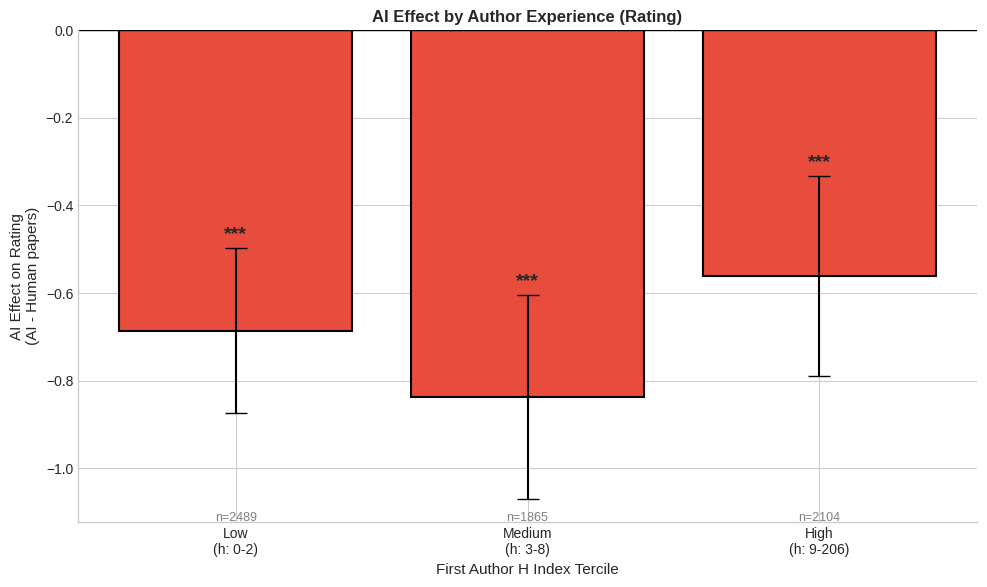

In [38]:
# H-Index Interaction Robustness Test (QJE/REStud-Ready)
from arxiv_integration.analysis import test_hindex_interactions_robust, create_hindex_interaction_figure

print("=" * 70)
print("H-INDEX INTERACTION ROBUSTNESS ANALYSIS")
print("=" * 70)

# Run comprehensive test with multiple testing correction
hindex_results = test_hindex_interactions_robust(
    df=merged,
    outcomes=['rating', 'soundness', 'presentation'],
    h_index_cols=['first_author_h_index', 'last_author_h_index', 'mean_author_h_index'],
    ai_col='ai_percentage',
    aggregate_to_paper=True,
    fdr_method='fdr_bh',  # Benjamini-Hochberg
    verbose=True,
    create_latex=True
)

# Save LaTeX table
if hindex_results.get('latex_table'):
    with open(f'{OUTPUT_DIR}/hindex_interaction_table.tex', 'w') as f:
        f.write(hindex_results['latex_table'])
    print(f"\nLaTeX table saved to: {OUTPUT_DIR}/hindex_interaction_table.tex")

# Create tercile figure for primary hypothesis
print("\n" + "=" * 70)
print("TERCILE VISUALIZATION: First Author H-Index × Rating")
print("=" * 70)

fig = create_hindex_interaction_figure(
    df=merged,
    outcome='rating',
    h_index_col='first_author_h_index',
    save_path=f'{OUTPUT_DIR}/fig_hindex_tercile_rating.png',
    verbose=True
)
plt.show()

## 7. Export Results for Paper

In [33]:
# Generate LaTeX table
def to_latex_table(df, caption, label):
    """Convert DataFrame to LaTeX table."""
    latex = df.to_latex(index=False, escape=False)
    latex = f"""\\begin{{table}}[htbp]
\\centering
\\caption{{{caption}}}
\\label{{{label}}}
{latex}
\\end{{table}}"""
    return latex

# Save LaTeX table
latex_table = to_latex_table(
    results['summary_table'],
    caption="Selection Robustness Tests: Author Ability Controls",
    label="tab:selection_robustness"
)

with open(f'{OUTPUT_DIR}/selection_robustness_table.tex', 'w') as f:
    f.write(latex_table)

print(f"\n✓ LaTeX table saved as {OUTPUT_DIR}/selection_robustness_table.tex")
print("\nPreview:")
print(latex_table[:500] + "...")


✓ LaTeX table saved as /content/HAI-Frontier/last_results/arxiv_author/selection_robustness_table.tex

Preview:
\begin{table}[htbp]
\centering
\caption{Selection Robustness Tests: Author Ability Controls}
\label{tab:selection_robustness}
\begin{tabular}{lllllll}
\toprule
Panel & Stratum & Estimate & SE & p-value & p-FDR & N \\
\midrule
A. Stratified by Author Reputation &  &  &  &  &  &  \\
 & Emerging & -0.6772 & 0.1035 & 0.0000 & 0.0000 & 8381 \\
 & Established & -0.8311 & 0.1077 & 0.0000 & 0.0000 & 8381 \\
 & Senior & -0.5494 & 0.1115 & 0.0000 & 0.0000 & 8381 \\
B. Interaction Model (Clustered SEs) &  ...


In [34]:
# Summary statistics for paper text
print("\n" + "="*70)
print("SUMMARY STATISTICS FOR PAPER")
print("="*70)

print(f"\n1. DATA COVERAGE")
print(f"   Total submissions: {results['n_total']}")
print(f"   With author data: {results['n_with_h_index']} ({100*results['coverage_rate']:.1f}%)")

print(f"\n2. AUTHOR REPUTATION DISTRIBUTION")
print(f"   First author h-index: median={enriched_df['first_author_h_index'].median():.0f}, "
      f"mean={enriched_df['first_author_h_index'].mean():.1f}")
print(f"   Last author h-index: median={enriched_df['last_author_h_index'].median():.0f}, "
      f"mean={enriched_df['last_author_h_index'].mean():.1f}")

print(f"\n3. KEY RESULTS")

# Stratified results
for tier, res in results['stratified']['by_stratum'].items():
    effect = res.get('interaction', res.get('mean_diff', 0))
    p = res.get('p_interaction', res.get('p_value', 1))
    sig = '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else ''))
    print(f"   {tier}: effect={effect:+.4f}, p={p:.4f} {sig}")

print(f"\n4. INTERACTION MODEL")
int_res = results['interaction']
print(f"   AI effect (at mean h-index): β={int_res['ai_effect']['coef']:.4f}, "
      f"p={int_res['ai_effect']['p']:.4f}")
print(f"   AI × h-index interaction: β={int_res['interaction']['coef']:.4f}, "
      f"p={int_res['interaction']['p']:.4f}")


SUMMARY STATISTICS FOR PAPER

1. DATA COVERAGE
   Total submissions: 75800
   With author data: 6458 (33.3%)

2. AUTHOR REPUTATION DISTRIBUTION
   First author h-index: median=4, mean=9.1
   Last author h-index: median=20, mean=26.0

3. KEY RESULTS
   Emerging: effect=-0.6772, p=0.0000 ***
   Established: effect=-0.8311, p=0.0000 ***
   Senior: effect=-0.5494, p=0.0000 ***

4. INTERACTION MODEL
   AI effect (at mean h-index): β=-0.2769, p=0.0000
   AI × h-index interaction: β=0.0546, p=0.0010


## 8. Interpretation

### Key Findings:

1. **Stratified Analysis**: If the AI-quality effect persists among high-h-index authors (Senior/Highly Cited tiers), this rules out pure selection.

2. **Interaction Model**: A non-significant AI × h-index interaction suggests the effect is uniform across ability levels (inconsistent with selection).

3. **Component Effects**: If Soundness declines more than Presentation even among high-reputation authors, this is the specific signature of AI substitution, not researcher quality.

In [35]:
# Final interpretation
print("\n" + "="*70)
print("FINAL INTERPRETATION")
print("="*70)

# Check if effect persists among senior authors
senior_results = results['stratified']['by_stratum'].get('Senior', {})
if senior_results:
    effect = senior_results.get('interaction', senior_results.get('mean_diff', 0))
    p = senior_results.get('p_interaction', senior_results.get('p_value', 1))

    if p < 0.05 and effect < 0:
        print("\n✓ SELECTION HYPOTHESIS REJECTED")
        print("\n  The negative relationship between AI content and quality persists")
        print("  even among high-reputation authors (h-index > 30).")
        print("\n  This is inconsistent with the selection explanation that")
        print("  'low-ability researchers simply overuse AI.'")
        print("\n  The pattern is consistent with AI substitution effects.")
    elif p >= 0.05:
        print("\n⚠ INCONCLUSIVE FOR SENIOR AUTHORS")
        print(f"\n  Effect not significant in senior tier (p={p:.4f}).")
        print("  This may be due to smaller sample size.")
        print("  Consider the interaction model results.")
else:
    print("\n⚠ SENIOR AUTHOR STRATUM NOT AVAILABLE")
    print("  Check h-index coverage and data quality.")

# Interaction result
int_p = results['interaction']['interaction']['p']
if int_p >= 0.05:
    print(f"\n✓ NO SIGNIFICANT INTERACTION (p={int_p:.4f})")
    print("  The AI effect is uniform across ability levels.")
    print("  This further weakens the selection argument.")


FINAL INTERPRETATION

✓ SELECTION HYPOTHESIS REJECTED

  The negative relationship between AI content and quality persists
  even among high-reputation authors (h-index > 30).

  This is inconsistent with the selection explanation that
  'low-ability researchers simply overuse AI.'

  The pattern is consistent with AI substitution effects.


In [36]:
print("\n" + "="*70)
print("Analysis complete!")
print("="*70)
print(f"\nOutputs saved to: {OUTPUT_DIR}/")
print("\n  Data files:")
print("  - data/iclr_submissions_enriched.csv (enriched submission data)")
print("\n  Robustness test results:")
print(f"  - {OUTPUT_DIR}/reviewer_robustness_summary.csv (3-row summary)")
print(f"  - {OUTPUT_DIR}/reviewer_robustness_detailed.csv (full statistics)")
print(f"  - {OUTPUT_DIR}/reviewer_robustness_report.txt (human-readable report)")
print(f"  - {OUTPUT_DIR}/reviewer_robustness_table.tex (LaTeX table for paper)")
print("\n  Selection robustness:")
print(f"  - {OUTPUT_DIR}/selection_robustness_table.csv (summary table)")
print(f"  - {OUTPUT_DIR}/selection_robustness_table.tex (LaTeX table)")
print("\n  Figures:")
print(f"  - {OUTPUT_DIR}/country_analysis_*.png (country visualizations)")
print(f"  - {OUTPUT_DIR}/selection_robustness_figure.png (stratified effects)")
print(f"  - {OUTPUT_DIR}/interaction_plot.png (AI × h-index interaction)")
print(f"  - {OUTPUT_DIR}/fig_*.png (additional figures)")
print("\n  Documentation:")
print("  - arxiv_integration/analysis/STATISTICAL_METHODS.md (methodology)")
print("\nSee STATISTICAL_METHODS.md for detailed documentation of all tests.")


Analysis complete!

Outputs saved to: /content/HAI-Frontier/last_results/arxiv_author/

  Data files:
  - data/iclr_submissions_enriched.csv (enriched submission data)

  Robustness test results:
  - /content/HAI-Frontier/last_results/arxiv_author/reviewer_robustness_summary.csv (3-row summary)
  - /content/HAI-Frontier/last_results/arxiv_author/reviewer_robustness_detailed.csv (full statistics)
  - /content/HAI-Frontier/last_results/arxiv_author/reviewer_robustness_report.txt (human-readable report)
  - /content/HAI-Frontier/last_results/arxiv_author/reviewer_robustness_table.tex (LaTeX table for paper)

  Selection robustness:
  - /content/HAI-Frontier/last_results/arxiv_author/selection_robustness_table.csv (summary table)
  - /content/HAI-Frontier/last_results/arxiv_author/selection_robustness_table.tex (LaTeX table)

  Figures:
  - /content/HAI-Frontier/last_results/arxiv_author/country_analysis_*.png (country visualizations)
  - /content/HAI-Frontier/last_results/arxiv_author/se

## 9. Push Results to GitHub

This section pushes **only the results** (figures, tables, output files) to GitHub - not the notebooks or code.
This ensures your paper always references the latest empirical results without manual intervention.

In [37]:
# Push only RESULTS to GitHub (not notebooks or code)
import subprocess
import os
from datetime import datetime

def push_results_to_github(
    repo_path="/content/HAI-Frontier",
    branch="main",
    commit_message=None,
    github_token=None
):
    """
    Push only RESULTS (figures, tables, CSVs) to GitHub - not notebooks or code.

    This function:
    1. Only stages result files from last_results/arxiv_author/
    2. Does NOT stage notebooks (.ipynb) or Python code (.py)
    3. Creates a commit with timestamp
    4. Pushes to the specified branch

    Results are organized in: last_results/arxiv_author/
    """

    # Get token if not provided
    if github_token is None:
        try:
            from google.colab import userdata
            github_token = userdata.get('GITHUB_TOKEN')
        except:
            return {"success": False, "message": "No GitHub token available", "files_pushed": []}

    os.chdir(repo_path)

    # Configure git identity (required for commits in Colab)
    subprocess.run(['git', 'config', 'user.email', 'colab@notebook.local'], capture_output=True)
    subprocess.run(['git', 'config', 'user.name', 'Colab Analysis Runner'], capture_output=True)

    # Result file patterns to push (organized in last_results/arxiv_author/)
    result_patterns = [
        'last_results/arxiv_author/*.png',
        'last_results/arxiv_author/*.pdf',
        'last_results/arxiv_author/*.csv',
        'last_results/arxiv_author/*.tex',
        'last_results/arxiv_author/*.txt',
        'last_results/arxiv_author/*.html',
        'last_results/arxiv_author/*.md',
        'last_results/arxiv_author/figures/*.png',
        'last_results/arxiv_author/figures/*.pdf',
        'last_results/arxiv_author/tables/*.tex',
        'last_results/arxiv_author/tables/*.csv',
        'data/iclr_submissions_enriched.csv',  # Enriched data
    ]

    # Find all result files
    files_to_add = []
    for pattern in result_patterns:
        import glob
        matches = glob.glob(pattern)
        files_to_add.extend(matches)

    # Remove duplicates and non-existent files
    files_to_add = list(set(f for f in files_to_add if os.path.exists(f)))

    if not files_to_add:
        return {"success": False, "message": "No result files found to push", "files_pushed": []}

    print(f"Found {len(files_to_add)} result files to push:")
    for f in sorted(files_to_add)[:20]:  # Show first 20
        print(f"  - {f}")
    if len(files_to_add) > 20:
        print(f"  ... and {len(files_to_add) - 20} more")

    # Stage only result files
    for f in files_to_add:
        subprocess.run(['git', 'add', f], capture_output=True)

    # Check if there are changes to commit
    status = subprocess.run(['git', 'status', '--porcelain'], capture_output=True, text=True)
    if not status.stdout.strip():
        return {"success": True, "message": "No changes to commit (results unchanged)", "files_pushed": []}

    # Generate commit message
    if commit_message is None:
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        commit_message = f"Update analysis results from arxiv_author_enrichment notebook ({timestamp})"

    # Commit
    commit_result = subprocess.run(
        ['git', 'commit', '-m', commit_message],
        capture_output=True, text=True
    )

    if commit_result.returncode != 0:
        return {"success": False, "message": f"Commit failed: {commit_result.stderr}", "files_pushed": []}

    print(f"\n✓ Committed: {commit_message}")

    # Configure remote with token
    remote_url = f"https://{github_token}@github.com/leippold/HAI-Frontier.git"
    subprocess.run(['git', 'remote', 'set-url', 'origin', remote_url], capture_output=True)

    # Push
    push_result = subprocess.run(
        ['git', 'push', 'origin', branch],
        capture_output=True, text=True
    )

    if push_result.returncode != 0:
        return {"success": False, "message": f"Push failed: {push_result.stderr}", "files_pushed": files_to_add}

    print(f"✓ Pushed to origin/{branch}")

    return {
        "success": True,
        "message": f"Successfully pushed {len(files_to_add)} result files",
        "files_pushed": files_to_add
    }

# Execute the push
print("=" * 70)
print("PUSHING RESULTS TO GITHUB")
print("=" * 70)
print("\nThis pushes ONLY result files (figures, tables, CSVs) - NOT notebooks or code.")
print("Results are organized in: last_results/arxiv_author/\n")

result = push_results_to_github(
    repo_path=f'/content/{REPO_NAME}',
    branch='main',
    github_token=GITHUB_TOKEN
)

print("\n" + "=" * 70)
if result['success']:
    print(f"SUCCESS: {result['message']}")
    print(f"Results location: last_results/arxiv_author/")
else:
    print(f"FAILED: {result['message']}")
print("=" * 70)

PUSHING RESULTS TO GITHUB

This pushes ONLY result files (figures, tables, CSVs) - NOT notebooks or code.
Results are organized in: last_results/arxiv_author/

Found 31 result files to push:
  - data/iclr_submissions_enriched.csv
  - last_results/arxiv_author/component_interaction_summary.csv
  - last_results/arxiv_author/country_analysis_bars.pdf
  - last_results/arxiv_author/country_analysis_bars.png
  - last_results/arxiv_author/country_analysis_summary.pdf
  - last_results/arxiv_author/country_analysis_summary.png
  - last_results/arxiv_author/country_map_quality.html
  - last_results/arxiv_author/country_map_quality.png
  - last_results/arxiv_author/country_map_volume.html
  - last_results/arxiv_author/country_map_volume.png
  - last_results/arxiv_author/fig_hindex_tercile_rating.png
  - last_results/arxiv_author/fig_substitution_stacked_regression.png
  - last_results/arxiv_author/geographic_analysis_summary.md
  - last_results/arxiv_author/hindex_interaction_table.tex
  - last_r